In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
if os.uname().sysname == 'Darwin':
    d = '/Users/ecekuru/Projects'
    os.chdir(d)
else:
    d = '/home/ecek/Projects'
    os.chdir(d)
from ASCAM.src.core.idealization import Idealizer 

In [3]:
def parse_color(rgba):
    r, g, b = [i / 255 for i in rgba[:3]]
    return r, g, b, rgba[-1]
def rgba(r, g, b, a):
    return parse_color((r, g, b, a))
def state_colors(rgba, i, j):
    new_rgba = list(rgba)
    colors = []
    for c in range(6):
        new_rgba[i] += (30 / 255)
        new_rgba[j] += (30 / 255)
        color = tuple(new_rgba)
        colors.append(color)
    return colors
disc_color = rgba(9, 104, 203, 0.8)
tc_color = rgba(214, 0, 0, 0.8)
disc_state_colors = state_colors(disc_color, 0, 1)
tc_state_colors = state_colors(tc_color, 1, 2)

##  Data

In [4]:
dataDir = 'SingleChannelIdealization/data/simulations'
tc_amplitudes = (
    # [0, -0.5, -1, -1.55, -2.25],
    [0, -0.6, -1.2, -1.8, -2.5],
    [0, -0.6, -1.2, -1.8, -2.5],
    # [0, -0.5, -1.1, -1.7, -2.35],
    [0, -0.6, -1.2, -1.8, -2.5],
    [0, -0.6, -1.2, -1.8, -2.5],
)
figDir = "../Nextcloud/Documents/UNI/MA/writing/StudyProject/figures"

In [5]:
def load_simulation_results(dir, schemeNo, snr, filter=None, sample=4e4):
    snrstr = str(float(snr)).replace('.', '_')
    if filter:
        trace = np.load(f"{dir}/scheme{schemeNo}/traces/current-trace-samplerate{int(sample)}-SNR{snrstr}-gf{int(filter)}.npy")*1e12  # in pA
    else:
        trace = np.load(f"{dir}/scheme{schemeNo}/traces/current-trace-samplerate{int(sample)}-SNR{snrstr}.npy")*1e12  # in pA
    
    time = np.linspace(0, len(trace)/sample, len(trace))*1e3  # in ms
    ground_truth = np.load(f"{dir}/scheme{schemeNo}/clean-traces/clean-current-trace-samplerate{int(sample)}.npy")*1e12  # pA
    return time, ground_truth, trace

In [6]:
def load_DISC_results(
    dir, schemeNo, snr, filter=1e3, sample=4e4,
    alpha=0.05, 
):
    snrstr = str(float(snr)).replace('.', '_')
    alphastr = str(alpha).replace('.', '_')
    if filter:
        fit = np.load(
            f"{dir}/scheme{schemeNo}/fits/current-trace-samplerate{int(sample)}-SNR{snrstr}-gf{int(filter)}_Alpha{alphastr}_ICHACBIC_ICdivsegBIC_minseg3_mincluster3_BICfull_.npy"
        )*1e12  # in pA
    else:
        fit = np.load(
            f"{dir}/scheme{schemeNo}/fits/current-trace-samplerate{int(sample)}-SNR{snrstr}_Alpha{alphastr}_ICHACBIC_ICdivsegBIC_minseg3_mincluster3_BICfull_.npy"
        )*1e12  # in pA
    time = np.linspace(0.5, 0.5+len(fit)/sample, len(fit))*1e3  # in ms
    return time, fit

In [7]:
def found_states_dict(dir, schemeNo):
    fitfiles = os.listdir(f"{dir}/scheme{schemeNo}/fits/")
    statesDict = {}
    for fitfile in fitfiles:
        fit = np.load(f"{dir}/scheme{schemeNo}/fits/{fitfile}")*1e12
        states = np.sort(np.unique(fit))
        statesDict[fitfile] = states
    return statesDict
def get_states(dict, dir, schemeNo, snr, sample, filter, alpha):
    snrstr = str(float(snr)).replace('.', '_')
    alphastr = str(alpha).replace('.', '_')
    if filter:
        key = f"current-trace-samplerate{int(sample)}-SNR{snrstr}-gf{int(filter)}_Alpha{alphastr}_ICHACBIC_ICdivsegBIC_minseg3_mincluster3_BICfull_.npy"
    else:
        key = f"current-trace-samplerate{int(sample)}-SNR{snrstr}_Alpha{alphastr}_ICHACBIC_ICdivsegBIC_minseg3_mincluster3_BICfull_.npy"
    return dict[key]

## Figures

In [8]:
def simulation_results_figure(
    starttime, endtime, zoomin, 
    snr=5, filter=1e3, sample=4e4, 
    savefigure=False,
):
    #f, axes = plt.subplots(4, 2, layout='constrained', figsize=(8,4))
    f = plt.figure(layout='constrained',figsize=(8,3))
    axes = f.subfigures(len(zoomin))

    for i, (ax, (starttime2, endtime2)) in enumerate(zip(axes, zoomin)):
        schemeNo = i + 1
        ax.suptitle(f"Scheme {schemeNo}")
        a = ax.subplots(2,1)
        time, gt, trace = load_simulation_results(dataDir, schemeNo, snr, filter=filter, sample=sample)
        start = np.argmax(time >= starttime)
        end = np.argmax(time >= endtime)
        a[0].plot(time[start:end], gt[start:end], linewidth=0.4, color='green', label='ground truth', alpha=0.7)
        a[0].plot(time[start:end], trace[start:end], linewidth=0.4, color='black', label='trace', alpha=0.7)
        a[0].axis("off")
        if filter:
                print(f'SNR {snr}, f {filter/1e3} kHz, samplerate {sample}')
        else:
            print(f'SNR {snr}, no filter, samplerate {sample}')
        a[0].set_ylim(-3.1, 0.4)
        a[0].set_xlim(starttime-20, endtime)
        a[0].vlines(starttime2, -3, 1, 'grey', linestyle='dashed')
        a[0].vlines(endtime2, -3, 1, 'grey', linestyle='dashed')
        a[0].hlines(-3, starttime2, endtime2, 'grey', linestyle='dashed')
        a[0].hlines(0.3, starttime2, endtime2, 'grey', linestyle='dashed')
        start2 = np.argmax(time >= starttime2)
        end2 = np.argmax(time >= endtime2)
        a[1].plot(time[start2:end2], gt[start2:end2], linewidth=0.9, color='green', label='ground truth', alpha=0.7)
        a[1].plot(time[start2:end2], trace[start2:end2], linewidth=0.9, color='black', label='trace', alpha=0.7)
        a[1].axis("off")
        if filter:
                print(f'SNR {snr}, f {filter/1e3} kHz, samplerate {sample}')
        else:
            print(f'SNR {snr}, no filter, samplerate {sample}')
        a[1].set_xlim(starttime2, endtime2)
        ymin = np.min(trace[start2:end2])
        ymax = np.max(trace[start2:end2])
        a[1].set_ylim(ymin, ymax)
        
        a[0].hlines(-2.5, starttime+60, starttime+160, 'k')
        a[0].vlines(starttime+60, -2.5, -1.5, 'k')
        a[0].text(starttime-8, -2.4, "1 pA")
        a[0].text(starttime+60, -3.6, "100 ms")

        a[1].hlines(ymin+0.1, starttime2+7, starttime2+12, 'k')
        a[1].vlines(starttime2+7, ymin+0.1, ymin+0.6, 'k')
        a[1].text(starttime2, ymin+0.2, "0.5 pA")
        a[1].text(starttime2+7.5, ymin*1.35, "5 ms")
    a[0].legend(loc="upper right")
    if savefigure:
        figname = f"sample-traces-figure"
        parameters = f"snr{snr}\nfilter{filter}\nsamplerate{sample}\n####################"
        with open(f"{figDir}/{figname}.txt", "a") as info:
            info.write(parameters)
        f.savefig(f"{figDir}/{figname}.png")
        f.savefig(f"{figDir}/{figname}.pdf")
    return f, axes

SNR 3, f 2.0 kHz, samplerate 150000.0
SNR 3, f 2.0 kHz, samplerate 150000.0
SNR 3, f 2.0 kHz, samplerate 150000.0
SNR 3, f 2.0 kHz, samplerate 150000.0
SNR 3, f 2.0 kHz, samplerate 150000.0
SNR 3, f 2.0 kHz, samplerate 150000.0


/home/ecek/.conda/envs/analysis/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


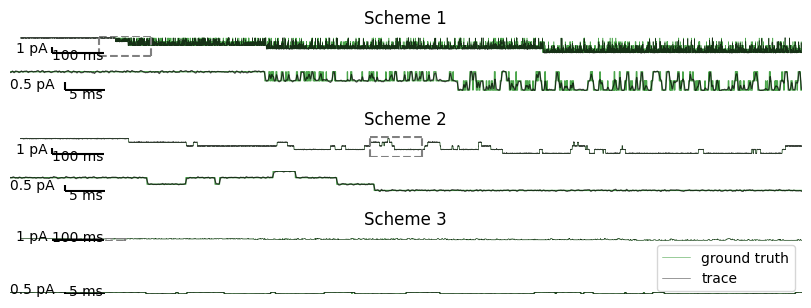

In [9]:
f, a = simulation_results_figure(
    500, 2000,
    zoomin=(
        (650, 750),
        (1172, 1272),
        (600, 700),
        #(1020, 1120),
    ),
    snr=3, filter=2e3, sample=15e4, savefigure=False,
)

In [233]:
def alpha_figure(
    dir, schemeNo,
    snrs=(1, 2, 3), filter=None, samples=(40000, 100000, 150000), 
    alphas=(0.05, 0.005, 1e-4, 1e-6, 1e-7, 1e-9),
    savefig=False,
):
    fulltime, gt, trace = load_simulation_results(dir, schemeNo, 3, filter=filter, sample=10e4)
    truestates = np.unique(gt)
    statesDict = found_states_dict(dir, schemeNo)
    f, axes = plt.subplots(len(samples), len(snrs), layout='constrained', figsize=(9,8))
    for s, sample in enumerate(samples):
        for n, snr in enumerate(snrs):
            a = axes[s,n]
            for alpha in alphas:
                a.hlines(truestates, 1e-9, 0.05, 'g')
                a.set_xlabel('$\\alpha$')
                fulltime, gt, trace = load_simulation_results(dir, schemeNo, snr, filter=filter, sample=sample)
                truestates = np.unique(gt)
                
                states = get_states(statesDict, dir, schemeNo, snr=snr, sample=sample, filter=filter, alpha=alpha)
                a.scatter([alpha for i in states], states, color=disc_color)
                a.set_xscale('log')
                
                a.set_title(f"SNR {snr}-{int(sample*1e-3)} kHz")
                a.set_ylabel("States [pA]")
            a.set_xticks([1e-6, 1e-2])
    f.suptitle(f"Scheme {schemeNo}")

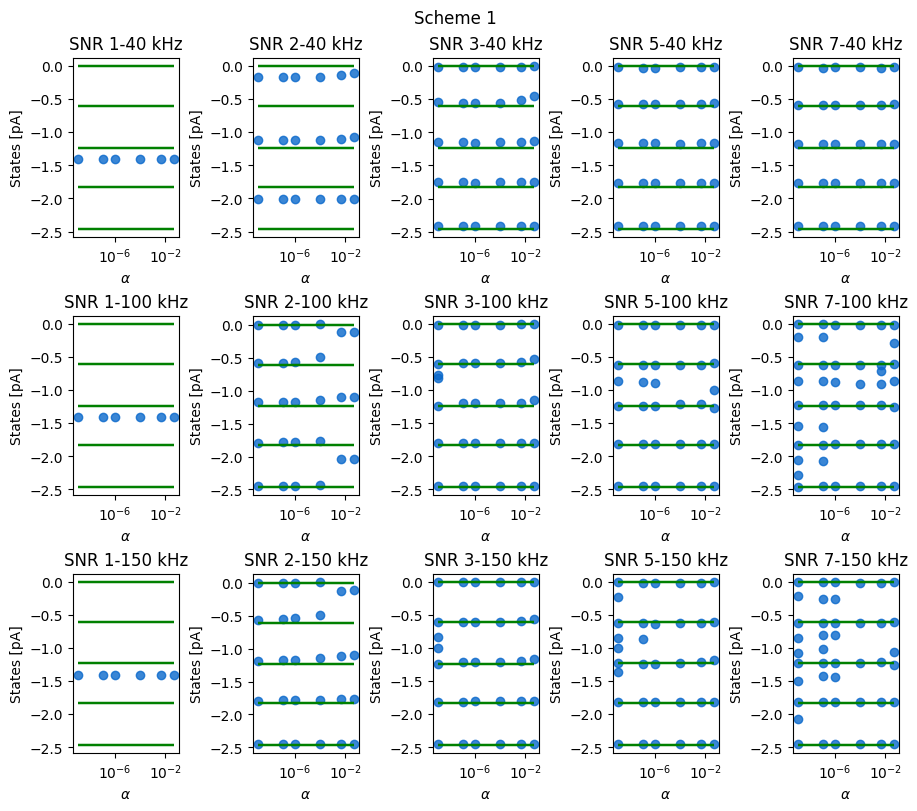

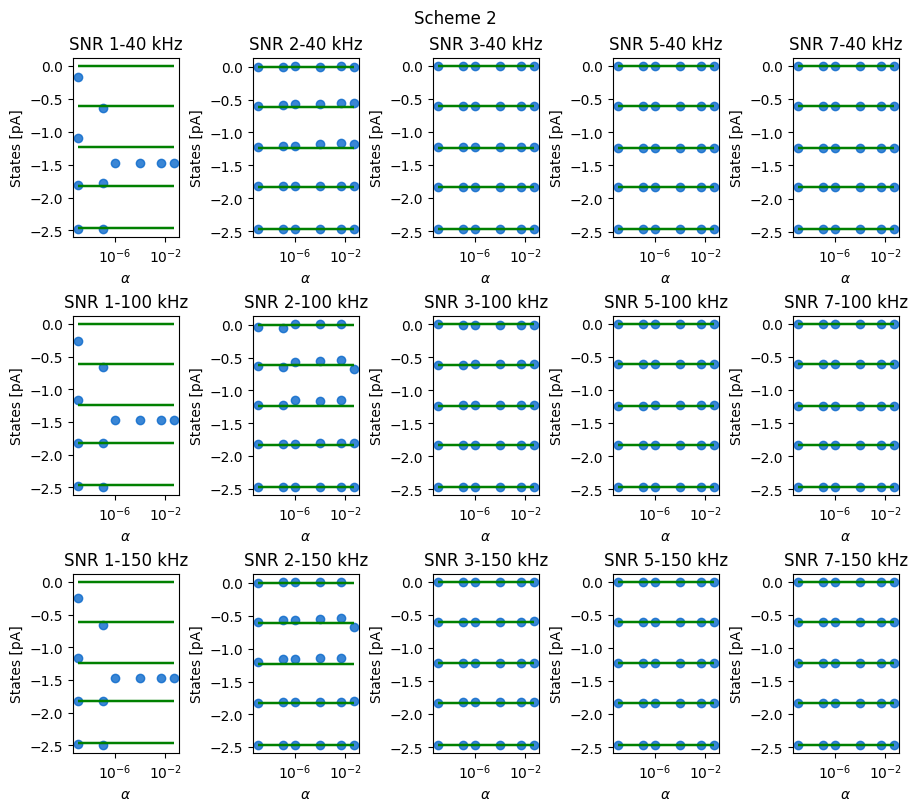

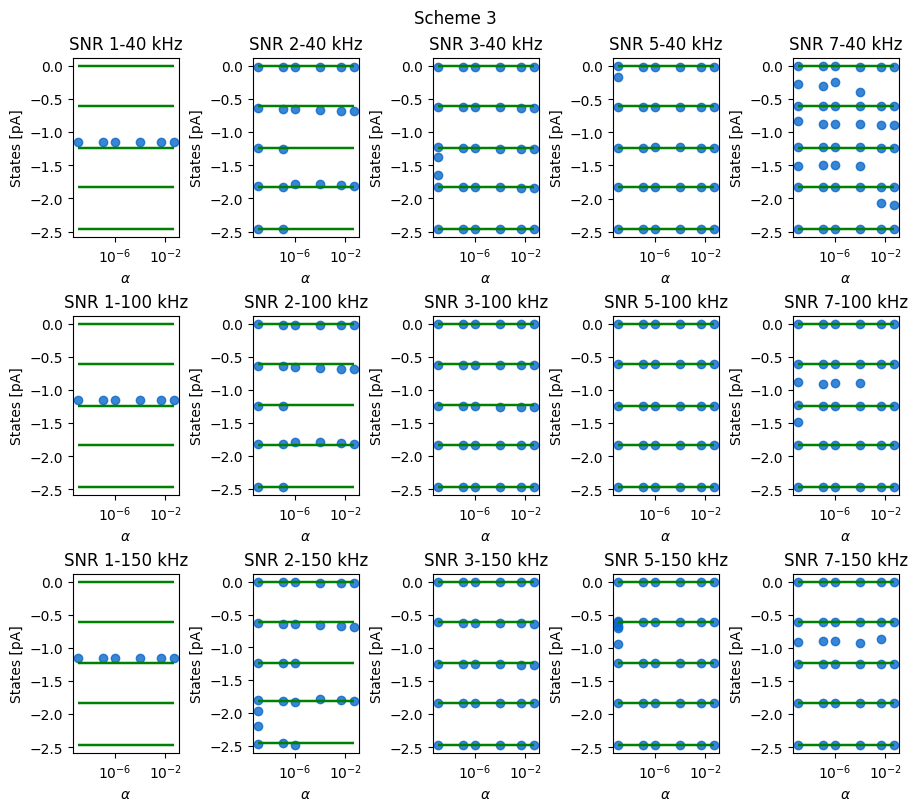

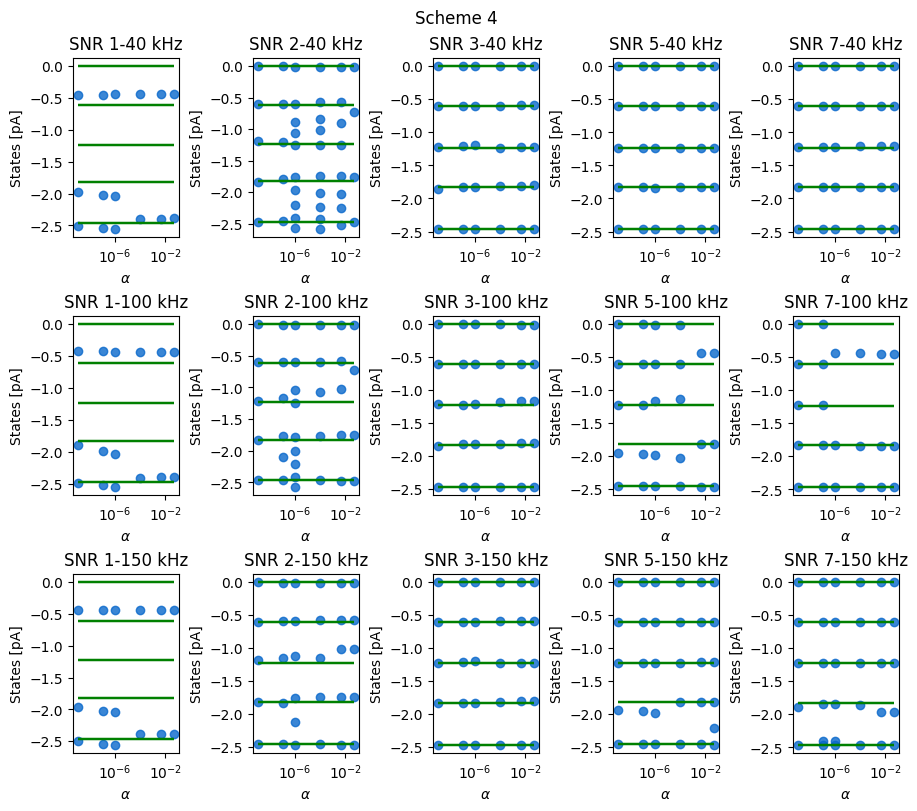

In [234]:
s = 1
filter = None
alpha_figure(dataDir, schemeNo=s, filter=filter, snrs=(1,2,3,5,7))
#plt.savefig(f"{figDir}/alphas-figure.png")
#plt.savefig(f"{figDir}/alphas-figure.pdf")
s = 2
filter = None
alpha_figure(dataDir, schemeNo=s, filter=filter, snrs=(1,2,3,5,7))
plt.savefig(f"{figDir}/../allplots/2/alphas-figure.png")
plt.savefig(f"{figDir}/../allplots/2/alphas-figure.pdf")
s = 3
filter = None
alpha_figure(dataDir, schemeNo=s, filter=filter, snrs=(1,2,3,5,7))
plt.savefig(f"{figDir}/../allplots/3/alphas-figure.png")
plt.savefig(f"{figDir}/../allplots/3/alphas-figure.pdf")
s = 4
filter = None
alpha_figure(dataDir, schemeNo=s, filter=filter, snrs=(1,2,3,5,7))
plt.savefig(f"{figDir}/../allplots/4/alphas-figure.png")
plt.savefig(f"{figDir}/../allplots/4/alphas-figure.pdf")

In [228]:
def disc_fit_results_figure(
    dir, schemeNo, snr, alphas, filter=1e3, sample=4e4, zoomin1=(700, 750), zoomin2=(720, 740),
    snrs=(1, 2, 3), alpha=1e-4, samples=(40000, 100000, 150000), filters=(100, 500, 1000, 2000, 5000, None),
    savefig=False,
):
    fulltime, gt, trace = load_simulation_results(dir, schemeNo, snr, filter=filter, sample=sample)
    truestates = np.unique(gt)
    f = plt.figure(
        layout='constrained',
        figsize=(13,8)
        #figsize=(20,10)
    )
    axes = f.subfigures(len(alphas), 2)
    for alpha, a in zip(alphas, axes[:,0]):
        a.suptitle("α = "+f"{alpha}")
        ax = a.subplots(3,1)
        time, fit = load_DISC_results(dir, schemeNo, snr, filter=filter, sample=sample, alpha=alpha)
        fitstates = np.unique(fit)
        nfit = len(fit)
        ax[0].plot(fulltime[-1*nfit:], trace[-1*nfit:], linewidth=0.4, alpha=0.7, color='darkgrey', label='trace')
        ax[0].plot(fulltime[-1*nfit:], gt[-1*nfit:], linewidth=0.4, alpha=0.7, color='green', label='ground truth')
        ax[0].plot(time, fit, linewidth=0.4, alpha=0.7, color=disc_color, label='DISC fit')
        
        ax[0].hlines(truestates, 500, 2000, color='grey', linewidth=0.4)
        ax[0].hlines(fitstates, 500, 2000, color=disc_state_colors[2], linewidth=0.4)
        ax[0].axis("off")

        for i, zoomin in enumerate((zoomin1, zoomin2)):
            ax[i].vlines(zoomin, -2.5, 0, 'k', linewidth=1.5)
            ax[i].hlines([-2.5, 0], zoomin[0], zoomin[1], 'k', linewidth=1.5)
            ax[i].text(
                zoomin[0] + (zoomin[1] - zoomin[0])/2, 0.3, f"{zoomin[1] - zoomin[0]} ms", 
                horizontalalignment='center',verticalalignment='center'
            )
            
            fitstartdidx = np.where(time >= zoomin[0])[0][0]
            fitendidx = np.where(time <= zoomin[1])[0][-1]
            tracestartdidx = np.where(fulltime >= zoomin[0])[0][0]
            traceendidx = np.where(fulltime <= zoomin[1])[0][-1]
            ax[i+1].plot(
                fulltime[tracestartdidx:traceendidx], trace[tracestartdidx:traceendidx],
                linewidth=0.9, alpha=0.7, color='darkgrey'
            )
            ax[i+1].plot(
                fulltime[tracestartdidx:traceendidx], gt[tracestartdidx:traceendidx],
                linewidth=0.9, alpha=0.7, color='green'
            )
            ax[i+1].plot(
                time[fitstartdidx:fitendidx], fit[fitstartdidx:fitendidx],
                linewidth=0.9, alpha=0.7, color=disc_color
            )
            ax[i+1].hlines(truestates, zoomin[0], zoomin[1], color='grey', linewidth=0.4)
            ax[i+1].hlines(fitstates, zoomin[0], zoomin[1], color=disc_state_colors[2], linewidth=0.4)
            ax[i+1].axis("off")
    leg = axes[0][0].legend()
    for legobj in leg.legend_handles:
        legobj.set_linewidth(1.0)


    statesDict = found_states_dict(dir, schemeNo)
    #f, a = plt.subplots(3, 3, layout='constrained', figsize=(8,8))
    for s, sample in enumerate(samples):
        a = axes[s,1].subplots(1, 3)
        for n, snr in enumerate(snrs):
            for filter in filters:
                fulltime, gt, trace = load_simulation_results(dir, schemeNo, snr, filter=filter, sample=sample)
                truestates = np.unique(gt)
                states = get_states(statesDict, dir, schemeNo, snr=snr, sample=sample, filter=filter, alpha=alpha)
                a[n].scatter([filter or 10000 for i in states], states, color=disc_color)
                a[n].set_xscale('log')
                a[n].hlines(truestates, 0, 10000, 'g')
                a[n].set_title(f"SNR {snr}-{int(sample*1e-3)} kHz")
                a[n].set_ylabel("States [pA]")
                a[n].set_xlabel("f$_c$ [Hz]")
    if savefig:
        figname = f"disc-results-figure"
        parametersfit = f"Fit (scheme {schemeNo}):\nsnr{snr}\nfilter{filter}\nsamplerate{sample}\nalphas{alphas}\n"
        parametersstates = f"States:\nsnrs{snrs}\nalpha{alpha}\nsamplerates{samples}\nfilters{filters}\n"
        with open(f"{figDir}/{figname}.txt", "a") as info:
            info.write(f"{parametersfit}----\n{parametersstates}####################\n")
        f.savefig(f"{figDir}/{figname}.png")
        f.savefig(f"{figDir}/{figname}.pdf")

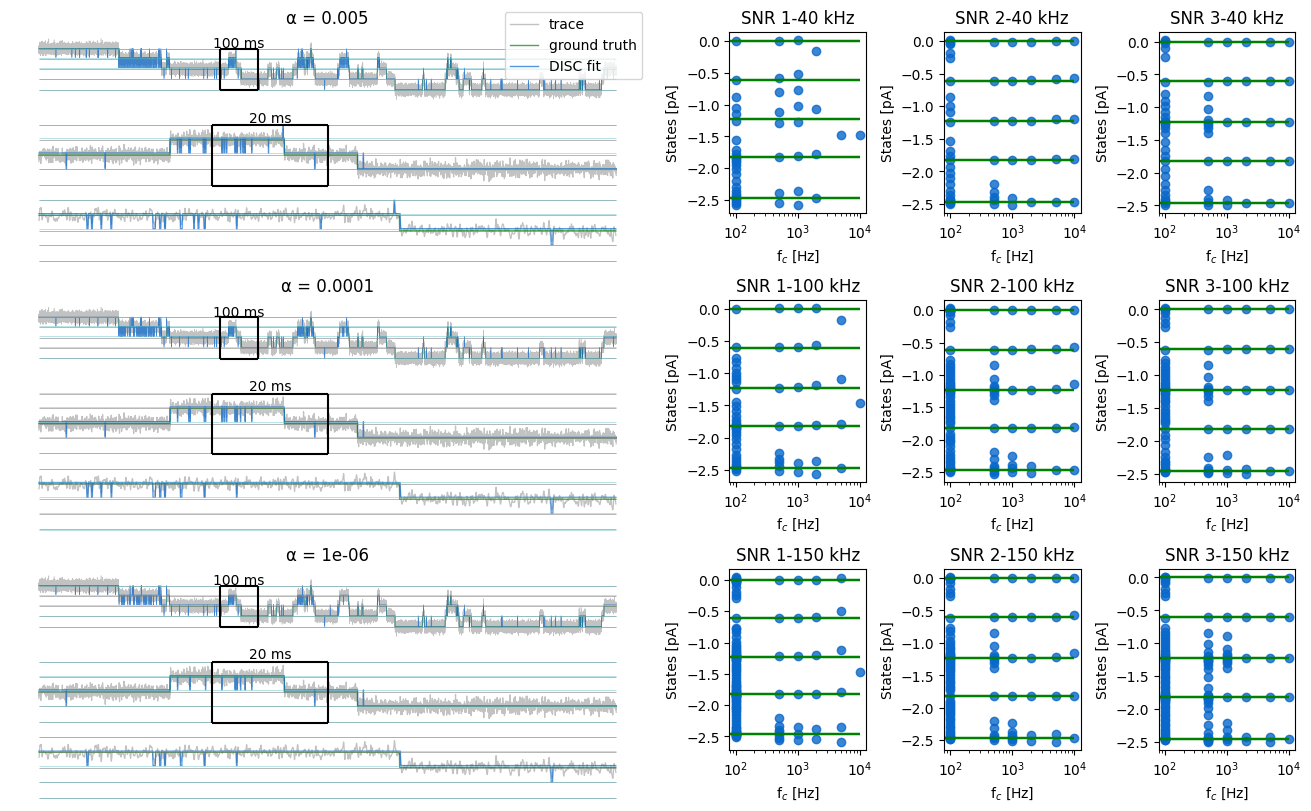

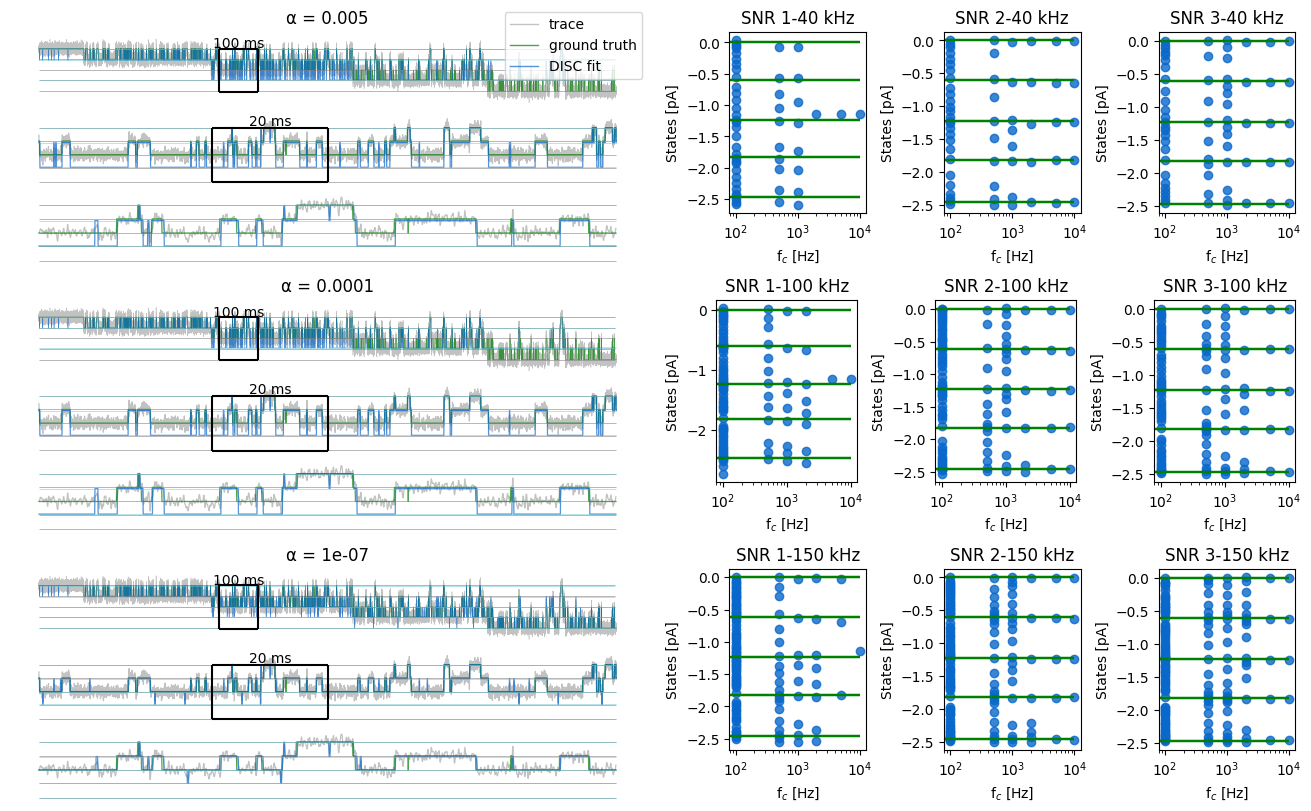

In [229]:
s = 2
snr = 2
alpha = 1e-6
disc_fit_results_figure(
    dataDir, s, snr, (0.005, 1e-4, 1e-6), sample=10e4, filter=None, 
    zoomin1=(970, 1070), zoomin2=(1000, 1020), 
    snrs=(1, 2, 3),
    alpha=alpha,
    savefig=False,
)
plt.savefig(f"{figDir}/../allplots/2/disc-results.pdf")
plt.savefig(f"{figDir}/../allplots/2/disc-results.png")
s = 3
snr = 2
alpha = 1e-7
disc_fit_results_figure(
    dataDir, s, snr, (0.005, 1e-4, 1e-7), sample=10e4, filter=None, 
    zoomin1=(970, 1070), zoomin2=(1000, 1020), 
    snrs=(1, 2, 3),
    alpha=alpha,
    savefig=False,
)
plt.savefig(f"{figDir}/../allplots/3/disc-results.pdf")
plt.savefig(f"{figDir}/../allplots/3/disc-results.png")

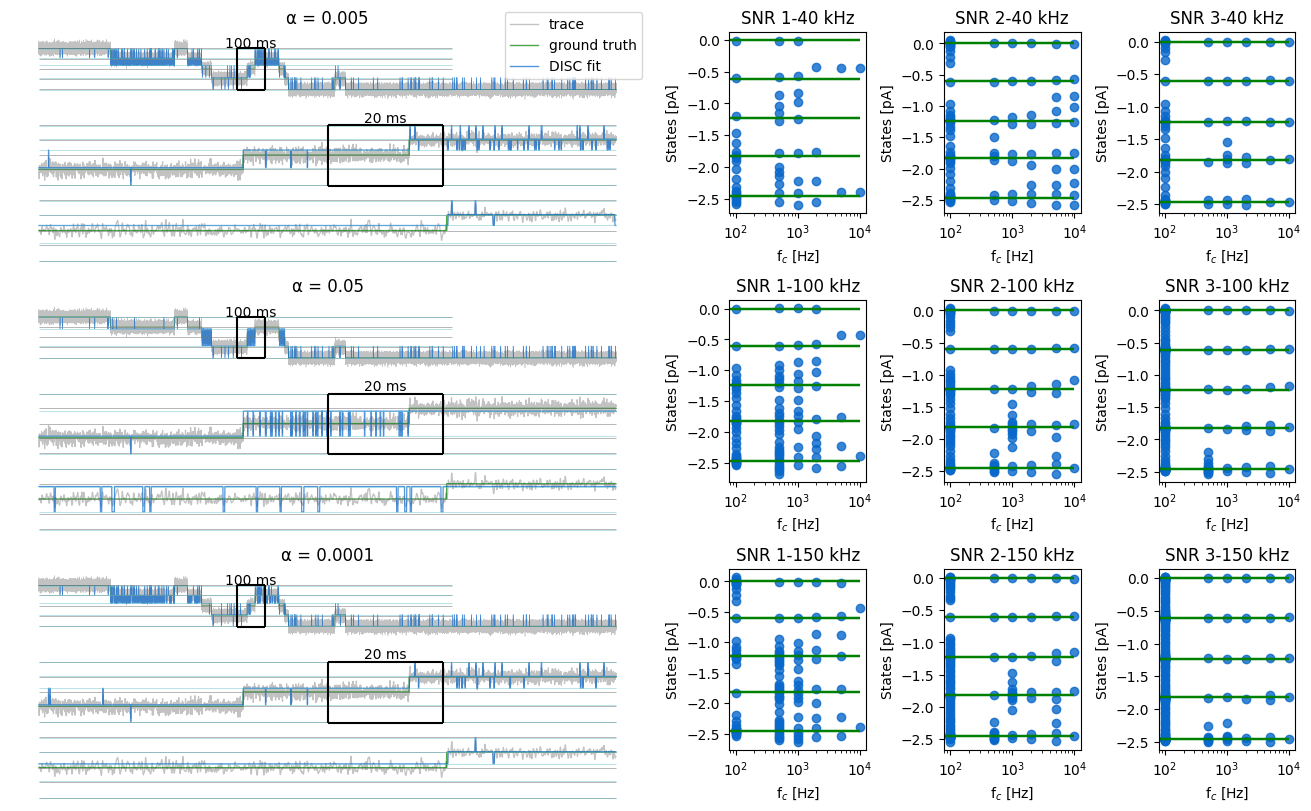

In [232]:
s = 4
snr = 2
alpha = 1e-4
disc_fit_results_figure(
    dataDir, s, snr, (0.005, 0.05, 1e-4), sample=10e4, filter=None, 
    zoomin1=(1220, 1320), zoomin2=(1270, 1290), 
    snrs=(1, 2, 3),
    alpha=alpha,
    savefig=False,
)
plt.savefig(f"{figDir}/../allplots/4/disc-results.pdf")
plt.savefig(f"{figDir}/../allplots/4/disc-results.png")

In [14]:
def threshold_crossing_amplitudes_figure(dir, amplitudes, snr, filter, sample, savefig=False):
    f, ax = plt.subplots(2, 1, layout='constrained', figsize= (8, 3))
    for i, (a, levels) in enumerate(zip(ax, amplitudes)):
        schemeNo = i + 1
        time, gt, trace = load_simulation_results(dir, schemeNo, snr=snr, filter=filter, sample=sample)
        a.plot(time, trace, color='darkgrey', linewidth=0.4)
        a.hlines(levels, 0, 2000, linewidth=0.8, color=tc_color, label="level")
        a.set_title(f"Scheme {schemeNo}")
        a.set_xlim(0, 2000)
        for j, l in enumerate(levels):
            if j < 4:
                threshold = l + (levels[j+1] - l)/2
                if j == 0:
                    a.hlines(threshold, 0, 2000, linewidth=0.6, color='orange', label="threshold")
                else:
                    a.hlines(threshold, 0, 2000, linewidth=0.6, color='orange')
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
        a.set_xlabel("Time [ms]")
        a.set_ylabel("I [pA]")
    ax[0].legend(framealpha=1)
    if savefig:
        figname = f"tc-levels-figure"
        parameters = f"snr{snr}\nfilter{filter}\nsamplerate{sample}\namplitudes: {amplitudes}####################"
        with open(f"{figDir}/{figname}.txt", "a") as info:
            info.write(parameters)
        f.savefig(f"{figDir}/{figname}.png")
        f.savefig(f"{figDir}/{figname}.pdf")

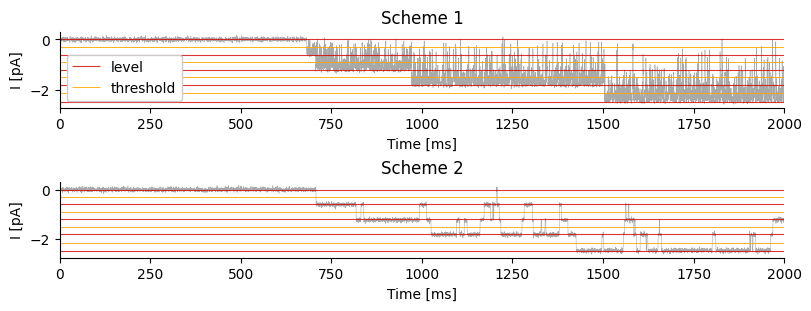

In [15]:
threshold_crossing_amplitudes_figure(
    dataDir, 
    tc_amplitudes, 
    2, 1e3, 100000, savefig=True,
)

In [14]:
def allpoint_histograms_figure(
     amplitudes, snr1=0.7, snr2=3, filter=1e3, sample=40000, savefigure=False
):
    #f, axes = plt.subplots(4, 4, layout='constrained', figsize=(10,5), sharex=True)
    f = plt.figure(layout='constrained',figsize=(10,5))
    axes = f.subfigures(1, 2)
    for j, filtered in enumerate((None, filter)):
        if filtered:
            axes[j].suptitle(f"Filtered at {int(filtered*1e-3)} kHz")
        else:
            axes[j].suptitle(" ")
        a = axes[j].subplots(4,2, sharex=True)
        for s in range(4):
            schemeNo = s + 1
            for k, snr in enumerate((snr1, snr2)):
                i = k + j*2
                time, gt, trace = load_simulation_results(dataDir, schemeNo, snr, filter=filtered, sample=sample)
                nbins = round(3.49 * np.std(trace) * len(trace) ** (1 / 3))
                f2, a2 = plt.subplots()
                weights, bins, _ = a2.hist(trace*-1, bins=nbins, density=True, alpha=0.3)
                plt.close()
                weights /= max(weights)
                a[s, k].bar(bins[:-1], weights, alpha=0.4, width=bins[1]-bins[0], color='green')
                states = np.sort(np.unique(gt))
                a[s, k].vlines(states*-1, 0, 1, color='darkgrey', alpha=0.6)
                a[s, k].vlines(np.array(amplitudes[s])*-1, 0, 1, color=tc_color, alpha=0.6)
                a[s, k].spines['top'].set_visible(False)
                a[s, k].spines['right'].set_visible(False)
                if schemeNo == 1:
                    a[s, k].set_title(f"SNR {snr}\nScheme {schemeNo}")
                else:
                    a[s, k].set_title(f"Scheme {schemeNo}")
                a[s, k].set_xlim(-0.5, 3)
                #a.set_ylabel("pdf/max(pdf)")

    #axes[-1][0].set_xlabel("Current [-1 pA]")
    #axes[-1][1].set_xlabel("Current [-1 pA]")
    if savefigure:
        figname = f"allpoint-histograms-figure"
        parameters = f"snr1{snr1}\nsnr2{snr2}\nfilter{filter}\nsamplerate{sample}\n####################"
        with open(f"{figDir}/{figname}.txt", "a") as info:
            info.write(parameters)
        f.savefig(f"{figDir}/{figname}.png")
        f.savefig(f"{figDir}/{figname}.pdf")

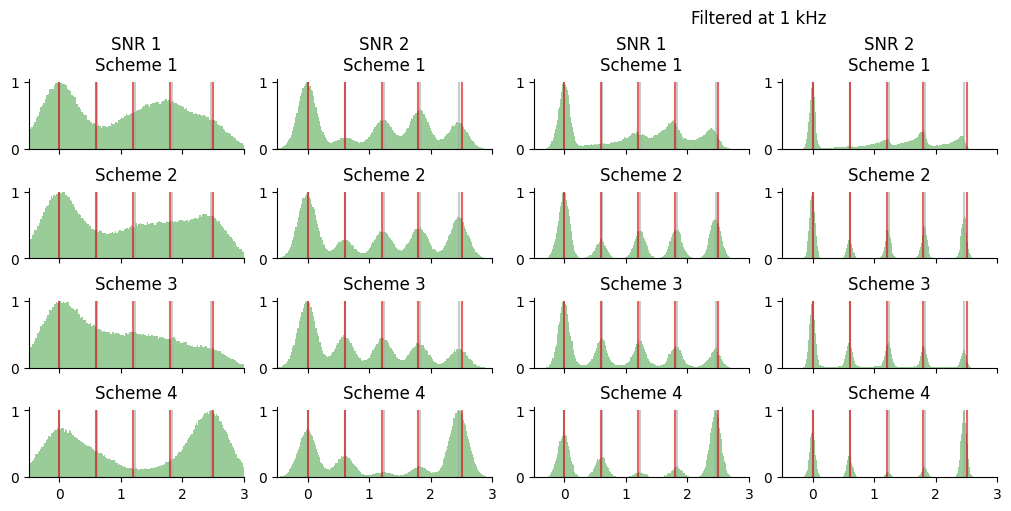

In [15]:
allpoint_histograms_figure(tc_amplitudes, snr1=1, snr2=2, filter=1e3, sample=100000, savefigure=False)

In [30]:
def tc_results_figure(
    dir, scheme, snr, sample, filters, zoomin1, zoomin2, amplitudes, resolution=0.00013, savefig=False, name=None,
):
    # f, axes = plt.subplots(3, 1, layout='constrained', figsize=(8, 4))
    f = plt.figure(layout='constrained',figsize=(8,5))
    sf = f.subfigures(len(filters))
    for filter, a in zip(filters, sf):
        a.suptitle(f"f$_c$ {int(filter)} Hz")
        time, gt, trace = load_simulation_results(dir, scheme, snr=snr, filter=filter, sample=sample)
        idealization, itime = Idealizer.TC_idealize_trace(trace, time, amplitudes, resolution=resolution)
        assert all(time ==  itime)
        axes = a.subplots(3)
        axes[0].plot(time, trace, linewidth=0.4, alpha=0.7, color='darkgrey', label="trace")
        axes[0].plot(time, gt, linewidth=0.4, alpha=0.7, color='green', label="ground truth")
        axes[0].plot(time, idealization, linewidth=0.4, alpha=0.7, color=tc_color, label="TC fit")
        axes[0].axis("off")
        for i, (zoomin, ax) in enumerate(zip((zoomin1, zoomin2), axes[1:])):
            axes[i].vlines(zoomin, -2.5, 0, 'k', linewidth=1.5)
            axes[i].hlines([-2.5, 0], zoomin[0], zoomin[1], 'k', linewidth=1.5)
            axes[i].text(
                zoomin[0] + (zoomin[1] - zoomin[0])/2, 0.3, f"{zoomin[1] - zoomin[0]} ms", 
                horizontalalignment='center',verticalalignment='center'
            )
            starttime, endtime = zoomin
            startid = np.where(time >= starttime)[0][0]
            endid = np.where(time <= endtime)[0][-1]
            ax.plot(time[startid:endid], trace[startid:endid], linewidth=0.9, alpha=0.7,color='darkgrey')
            ax.plot(time[startid:endid], idealization[startid:endid], linewidth=0.9, alpha=0.7, color=tc_color)
            ax.plot(time[startid:endid], gt[startid:endid], linewidth=0.9, alpha=0.7,color='green')
            ax.axis("off")
    leg = sf[0].legend()
    for legobj in leg.legend_handles:
        legobj.set_linewidth(1.0)

    if savefig:
        if name:
            figname = f"tc-results-supp-{name}"
            parameterprefix = f"{name}"
        else:
            figname = f"tc-results-figure"
            parameterprefix = ""
        parameters = f"{parameterprefix}snr{snr}\nfilter{filter}\nsamplerate{sample}\namplitudes{amplitudes}\nresolution{resolution}\n####################\n\n"
        with open(f"{figDir}/{figname}.txt", "a") as info:
            info.write(parameters)
        f.savefig(f"{figDir}/{figname}.png")
        f.savefig(f"{figDir}/{figname}.pdf")

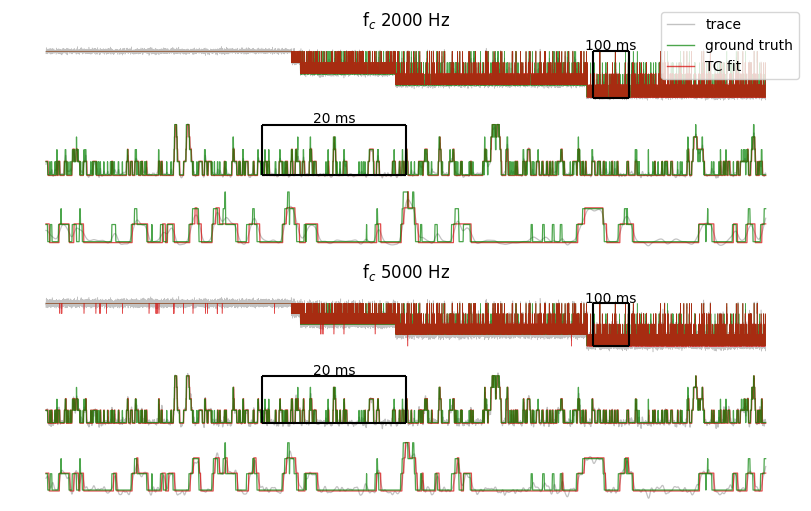

In [100]:
s = 1
tc_results_figure(
    dataDir, s, snr=2, sample=100000, filters=(2e3, 5e3), zoomin1=(1520, 1620), zoomin2=(1550, 1570), 
    amplitudes=np.array(tc_amplitudes[s-1]), resolution=0.13*1e-3, savefig=False, name=None,
)

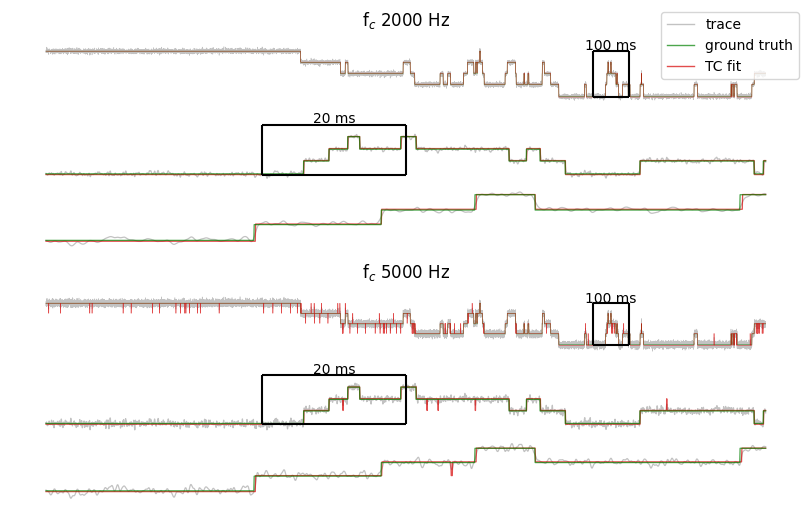

In [199]:
s = 2
tc_results_figure(
    dataDir, s, snr=2, sample=100000, filters=(2e3, 5e3), zoomin1=(1520, 1620), zoomin2=(1550, 1570), 
    amplitudes=np.array(tc_amplitudes[s-1]), resolution=0.13*1e-3, savefig=False, name=None,
)
plt.savefig(f"{figDir}/../allplots/2/tc-results.pdf")
plt.savefig(f"{figDir}/../allplots/2/tc-results.png")

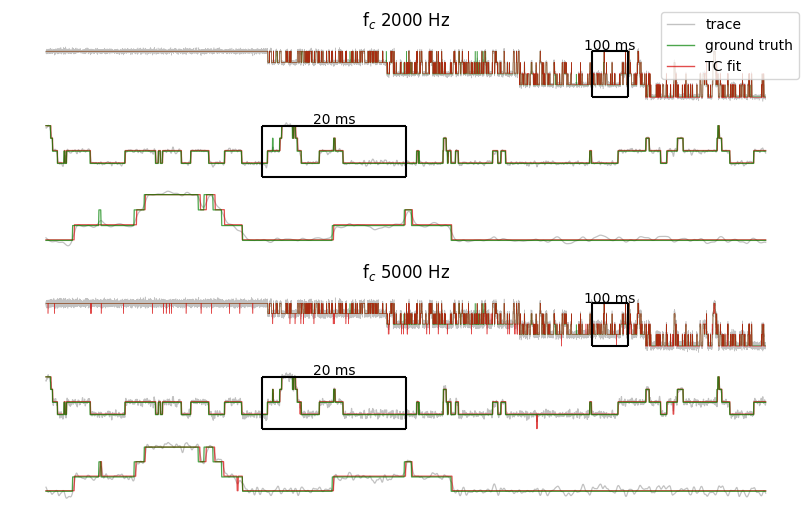

In [201]:
s = 3
tc_results_figure(
    dataDir, s, snr=2, sample=100000, filters=(2e3, 5e3), zoomin1=(1520, 1620), zoomin2=(1550, 1570), 
    amplitudes=np.array(tc_amplitudes[s-1]), resolution=0.13*1e-3, savefig=False, name=None,
)
plt.savefig(f"{figDir}/../allplots/3/tc-results.pdf")
plt.savefig(f"{figDir}/../allplots/3/tc-results.png")

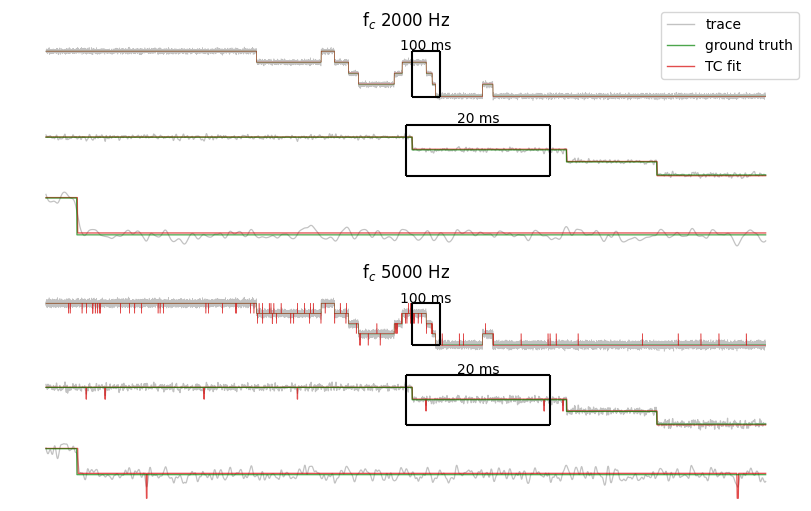

In [205]:
s = 4
tc_results_figure(
    dataDir, s, snr=2, sample=100000, filters=(2e3, 5e3), zoomin1=(1320, 1420), zoomin2=(1370, 1390), 
    amplitudes=np.array(tc_amplitudes[s-1]), resolution=0.13*1e-3, savefig=False, name=None,
)
plt.savefig(f"{figDir}/../allplots/4/tc-results.pdf")
plt.savefig(f"{figDir}/../allplots/4/tc-results.png")

In [37]:
def supp_dwell_times_figure3(
    dir, scheme, snr, sample,
    amplitudes, tcfilter, resolution,
    alpha,
    savefig=False,
):
    time, gt, trace = load_simulation_results(dir, scheme, snr=snr, filter=tcfilter, sample=sample)
    tcfit, tctime = Idealizer.TC_idealize_trace(trace, time, amplitudes, resolution=resolution)
    disctime, discfit = load_DISC_results(dir, scheme, snr, filter=None, sample=sample, alpha=alpha)
    n = 5 # len(set(gt))
    f, axes = plt.subplot_mosaic(
        [['1', '1', '2', '2', '3', '3'], ['.', '4', '4', '5', '5', '.']],
        layout='constrained', figsize=(8,6))
    for fit, t, color, label in zip(
        (gt, tcfit, discfit), (time, tctime, disctime), ('green', tc_color, disc_color), ('sim.', 'TC', 'DISC')
    ):
        print(np.std(fit))
        startid = np.where(t >= 500)[0][0]
        events_table = Idealizer.extract_events(fit[startid:], t[startid:])  # columns: amplitudes, durations, start, end
        states = np.sort(np.unique(fit))[-1::-1]
        print([round(s, 2) for s in states])
        count = 0
        for i, state in enumerate(states):
            if label == "DISC" and i == 2:
                ax = axes[str(i+1+1)]
            else:
                ax = axes[str(i+1)]
            eventids = np.where(events_table[:,0] == state)[0]
            durations = events_table[eventids, 1]
            nbins = round(3.49 * np.std(durations) * len(durations) ** (1 / 3))
            #print(nbins)
            if i == 0:
                nbins = 23
            else:
                ...
                #nbins = 17
            f2, a2 = plt.subplots()
            hist, bins, _ = a2.hist(durations, bins=21)  # 21
            logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
            hist, bins, _ = a2.hist(durations,alpha=0.4, bins=logbins)
            plt.close()
            x = bins[1:] + (bins[1:] - bins[:-1]) / 2
            y = hist.view()
            ax.set_xscale('log')
            #ax.scatter(x, y*1/2, color=color)
            ax.plot(x, y, color=color, label=label, alpha=0.6)
            ax.vlines(0.3321/tcfilter*1e3, 0, max(y), color='grey', linestyle='dashed', label="T$_r$")
            ax.set_title(f"State {i}")
            ax.legend()
            print(f"{len(durations)} events at state {i} for {label}")
            count += len(durations)
    return f, axes

In [38]:
def supp_dwell_times_figure_slow(
    dir, scheme, snr, sample,
    amplitudes, tcfilter, resolution,
    alpha,
    savefig=False,
):
    time, gt, trace = load_simulation_results(dir, scheme, snr=snr, filter=tcfilter, sample=sample)
    tcfit, tctime = Idealizer.TC_idealize_trace(trace, time, amplitudes, resolution=resolution)
    disctime, discfit = load_DISC_results(dir, scheme, snr, filter=None, sample=sample, alpha=alpha)
    n = 5 # len(set(gt))
    f, axes = plt.subplot_mosaic(
        [['1', '1', '2', '2', '3', '3'], ['.', '4', '4', '5', '5', '.']],
        layout='constrained', figsize=(8,6))
    for fit, t, color, label in zip(
        (gt, tcfit, discfit), (time, tctime, disctime), ('green', tc_color, disc_color), ('sim.', 'TC', 'DISC')
    ):
        print(np.std(fit))
        startid = np.where(t >= 500)[0][0]
        events_table = Idealizer.extract_events(fit[startid:], t[startid:])  # columns: amplitudes, durations, start, end
        states = np.sort(np.unique(fit))[-1::-1]
        print([round(s, 2) for s in states])
        count = 0
        for i, state in enumerate(states):
            if label == 'DISC':
                ax = axes[str(i+1)].twinx()
                ax.tick_params(colors=disc_color)
            else:
                ax = axes[str(i+1)]
            eventids = np.where(events_table[:,0] == state)[0]
            durations = events_table[eventids, 1]
            nbins = round(3.49 * np.std(durations) * len(durations) ** (1 / 3))
            #print(nbins)
            if i == 0:
                nbins = 23
            else:
                ...
                #nbins = 17
            f2, a2 = plt.subplots()
            hist, bins, _ = a2.hist(durations, bins=17)  # 21
            logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
            hist, bins, _ = a2.hist(durations,alpha=0.4, bins=logbins)
            plt.close()
            x = bins[1:] + (bins[1:] - bins[:-1]) / 2
            y = hist.view()
            ax.set_xscale('log')
            #ax.scatter(x, y*1/2, color=color)
            ax.plot(x, y, color=color, label=label, alpha=0.6)
            ax.vlines(0.3321/tcfilter*1e3, 0, max(y), color='grey', linestyle='dashed', label="T$_r$")
            ax.set_title(f"State {i}")
            ax.legend()
            print(f"{len(durations)} events at state {i} for {label}")
            count += len(durations)
        print(f"{count} events in total for {label}")
    return f, axes

In [176]:
def dwell_times_figure(
    dir, scheme, snr, sample,
    amplitudes, tcfilter, resolution,
    alpha,
    savefig=False,
):
    if scheme == 3 and snr == 2 and alpha >= 1e-6:
        f, axes = supp_dwell_times_figure3(dir, scheme, snr, sample, amplitudes, tcfilter, resolution, alpha)
    elif scheme in (2, 4) and snr == 2 and alpha >= 1e-4:
        f, axes = supp_dwell_times_figure_slow(dir, scheme, snr, sample, amplitudes, tcfilter, resolution, alpha)
    time, gt, trace = load_simulation_results(dir, scheme, snr=snr, filter=tcfilter, sample=sample)
    tcfit, tctime = Idealizer.TC_idealize_trace(trace, time, amplitudes, resolution=resolution)
    disctime, discfit = load_DISC_results(dir, scheme, snr, filter=None, sample=sample, alpha=alpha)
    n = 5 # len(set(gt))
    f, axes = plt.subplot_mosaic(
        [['1', '1', '2', '2', '3', '3'], ['.', '4', '4', '5', '5', '.']],
        layout='constrained', figsize=(8,6))
    titles = ("C", "O1", "O2", "O3", "O4")
    for fit, t, color, label in zip(
        (gt, tcfit, discfit), (time, tctime, disctime), ('green', tc_color, disc_color), ('sim.', 'TC', 'DISC')
    ):
        print(np.std(fit))
        startid = np.where(t >= 500)[0][0]
        events_table = Idealizer.extract_events(fit[startid:], t[startid:])  # columns: amplitudes, durations, start, end
        states = np.sort(np.unique(fit))[-1::-1]
        print([round(s, 2) for s in states])
        count = 0
        for i, state in enumerate(states):
            ax = axes[str(i+1)]
            eventids = np.where(events_table[:,0] == state)[0]
            durations = events_table[eventids, 1]
            nbins = round(3.49 * np.std(durations) * len(durations) ** (1 / 3))
            #print(nbins)
            if i == 0:
                nbins = 21
                ...
            else:
                ...
                #nbins = 17
            f2, a2 = plt.subplots()
            hist, bins, _ = a2.hist(durations, bins=nbins)  # 21
            logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
            hist, bins, _ = a2.hist(durations,alpha=0.4, bins=logbins)
            plt.close()
            x = bins[1:] + (bins[1:] - bins[:-1]) / 2
            y = hist.view()
            ax.set_xscale('log')
            #ax.scatter(x, y*1/2, color=color)
            if label == 'sim.':
                tcfilter = tcfilter or 10e3
                ax.vlines(0.3321/tcfilter*1e3, 0, 42, color='grey', linestyle='dashed')#, label="T$_r$")
            ax.plot(x, y, color=color, label=label, alpha=0.6)
            print(f"{len(durations)} events at state {i} for {label}")
            count += len(durations)
            ax.set_xlabel("Dwell time [ms]")
            ax.set_ylabel("Counts")
            ax.set_title(f"{titles[i]}")
            #ax.set_ylim(0, 510)
            ax.legend()
        print(f"{count} events in total for {label}")
    if savefig:
        f.savefig(f"{figDir}/dwell-times-scheme{scheme}.pdf")
        f.savefig(f"{figDir}/dwell-times-scheme{scheme}.png")

0.9321299569806586
[-0.0, -0.61, -1.23, -1.82, -2.46]
389 events at state 0 for sim.
1338 events at state 1 for sim.
2331 events at state 2 for sim.
2281 events at state 3 for sim.
921 events at state 4 for sim.
7260 events in total for sim.
0.9353992889144183
[0.0, -0.6, -1.2, -1.8, -2.5]
288 events at state 0 for TC
969 events at state 1 for TC
1662 events at state 2 for TC
1658 events at state 3 for TC
678 events at state 4 for TC
5255 events in total for TC
0.8137176703679609
[0.01, -0.49, -1.14, -1.77, -2.44]
365 events at state 0 for DISC
1086 events at state 1 for DISC
1733 events at state 2 for DISC
1763 events at state 3 for DISC
752 events at state 4 for DISC
5699 events in total for DISC


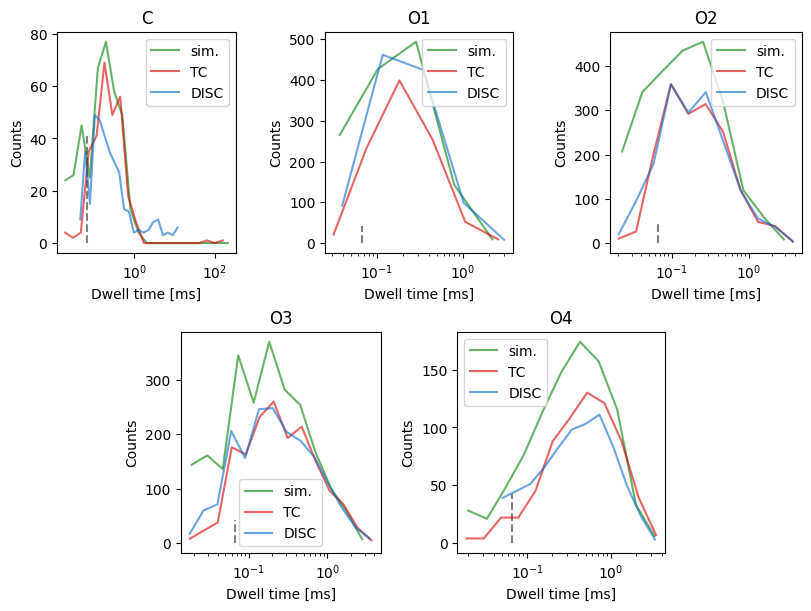

In [206]:
s = 1
dwell_times_figure(
    dataDir, scheme=s, snr=2, sample=100000, 
    amplitudes=tc_amplitudes[s-1], tcfilter=5e3, 
    resolution=0.13*1e-3, alpha=1e-4, savefig=False,
)

0.8584715678410615
[-0.0, -0.61, -1.23, -1.82, -2.46]
118 events at state 0 for sim.
239 events at state 1 for sim.
215 events at state 2 for sim.
152 events at state 3 for sim.
61 events at state 4 for sim.
785 events in total for sim.
0.8603936670610843
[0.0, -0.6, -1.2, -1.8, -2.5]
122 events at state 0 for TC
255 events at state 1 for TC
247 events at state 2 for TC
179 events at state 3 for TC
66 events at state 4 for TC
869 events in total for TC
0.8056039529879171
[-0.01, -0.63, -1.24, -1.82, -2.47]
136 events at state 0 for DISC
289 events at state 1 for DISC
274 events at state 2 for DISC
194 events at state 3 for DISC
74 events at state 4 for DISC
967 events in total for DISC


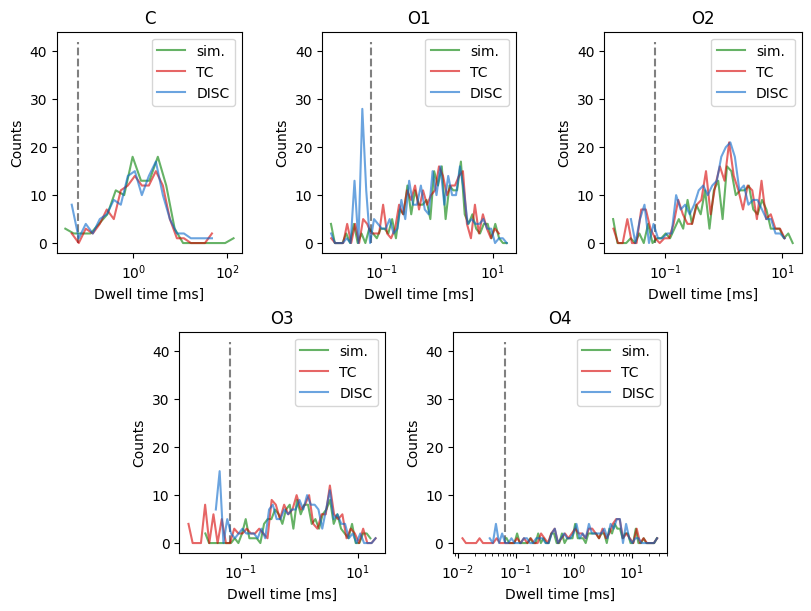

In [209]:
s = 3
dwell_times_figure(
    dataDir, scheme=s, snr=2, sample=100000, 
    amplitudes=tc_amplitudes[s-1], tcfilter=5e3, 
    resolution=0.13*1e-3, alpha=1e-9, savefig=False,
)
plt.savefig(f"{figDir}/../allplots/3/dwell-times.pdf")
plt.savefig(f"{figDir}/../allplots/3/dwell-times.png")

1.101087615809057
[-0.0, -0.61, -1.23, -1.82, -2.46]
2 events at state 0 for sim.
3 events at state 1 for sim.
3 events at state 2 for sim.
3 events at state 3 for sim.
2 events at state 4 for sim.
13 events in total for sim.
1.117441852428128
[0.0, -0.6, -1.2, -1.8, -2.5]
24 events at state 0 for TC
44 events at state 1 for TC
31 events at state 2 for TC
30 events at state 3 for TC
20 events at state 4 for TC
149 events in total for TC
0.9787687384189483
[-0.01, -0.61, -1.22, -1.82, -2.46]
35 events at state 0 for DISC
79 events at state 1 for DISC
57 events at state 2 for DISC
275 events at state 3 for DISC
263 events at state 4 for DISC
709 events in total for DISC


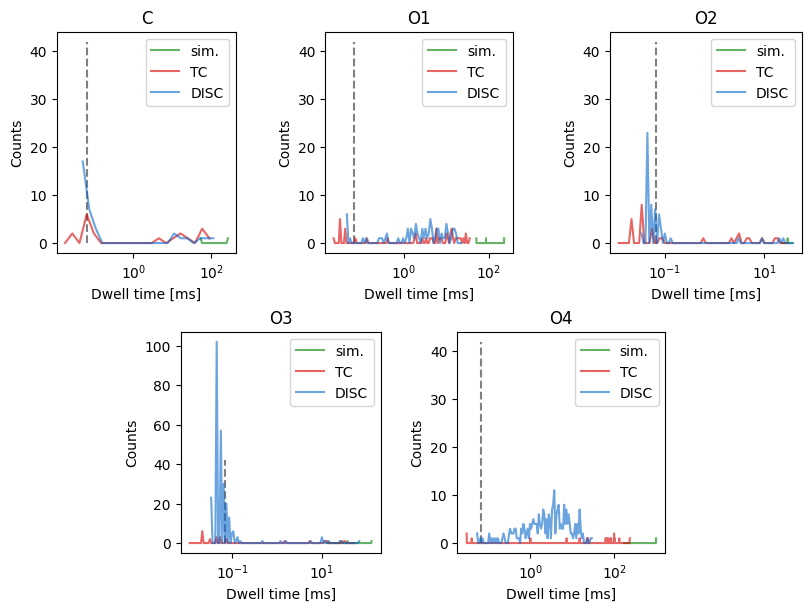

In [210]:
s = 4
dwell_times_figure(
    dataDir, scheme=s, snr=2, sample=100000, 
    amplitudes=tc_amplitudes[s-1], tcfilter=5e3, 
    resolution=0.13*1e-3, alpha=1e-9, savefig=False,
)

In [222]:
def dwell_times_tc_figure(
    dir, scheme, snr, sample,
    amplitudes, resolution,
    savefig=False,
):
    n = 5 # len(set(gt))
    f, axes = plt.subplot_mosaic(
        [['1', '1', '2', '2', '3', '3'], ['.', '4', '4', '5', '5', '.']],
        layout='constrained', figsize=(8,6))
    titles = ("C", "O1", "O2", "O3", "O4")
    for filter, color in zip((None, 5e3, 2e3, 1e3, 5e2, 1e2, -1), tc_state_colors+['green']):
        if filter == -1:
            time, gt, trace = load_simulation_results(dir, scheme, snr=snr, filter=None, sample=sample)
            fit = gt
        else:
            time, gt, trace = load_simulation_results(dir, scheme, snr=snr, filter=filter, sample=sample)
            fit, tctime = Idealizer.TC_idealize_trace(trace, time, amplitudes, resolution=resolution)
        t = time
        startid = np.where(time >= 500)[0][0]
        events_table = Idealizer.extract_events(fit[startid:], t[startid:])  # columns: amplitudes, durations, start, end
        states = np.sort(np.unique(fit))[-1::-1]
        print([round(s, 2) for s in states])
        count = 0
        for i, state in enumerate(states):
            ax = axes[str(i+1)]
            eventids = np.where(events_table[:,0] == state)[0]
            durations = events_table[eventids, 1]
            nbins = round(3.49 * np.std(durations) * len(durations) ** (1 / 3))
            #print(nbins)
            if i == 0:
                nbins = 21
                ...
            else:
                ...
                #nbins = 17
            f2, a2 = plt.subplots()
            hist, bins, _ = a2.hist(durations, bins=nbins)  # 21
            logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
            hist, bins, _ = a2.hist(durations,alpha=0.4, bins=logbins)
            plt.close()
            x = bins[1:] + (bins[1:] - bins[:-1]) / 2
            y = hist.view()
            ax.set_xscale('log')
            #ax.scatter(x, y*1/2, color=color)
            #if label == 'sim.':
            #    tcfilter = tcfilter or 10e3
            #    ax.vlines(0.3321/tcfilter*1e3, 0, 1000, color='grey', linestyle='dashed')#, label="T$_r$")
            if filter and filter > 0:
                if filter >= 1e3:
                    label = f"{int(filter/1000)}"
                else:
                    label = f"{filter/1000}"
            elif filter == -1:
                label = 'sim'
            else:
                label = "10"
            ax.plot(x, y, color=color, label=label, alpha=0.6)
            #print(f"{len(durations)} events at state {i} for {label}")
            count += len(durations)
            ax.set_xlabel("Dwell time [ms]")
            ax.set_ylabel("Counts")
            ax.set_title(f"{titles[i]}")
            ax.set_xlim(1e-2, 1e2)
            ax.set_ylim(0, 720)
            ax.legend()
        #print(f"{count} events in total for {label}")
    if savefig:
        f.savefig(f"{figDir}/dwell-times-scheme{scheme}.pdf")
        f.savefig(f"{figDir}/dwell-times-scheme{scheme}.png")

[0.0, -0.6, -1.2, -1.8, -2.5]
[0.0, -0.6, -1.2, -1.8, -2.5]
[0.0, -0.6, -1.2, -1.8, -2.5]
[0.0, -0.6, -1.2, -1.8, -2.5]
[0.0, -0.6, -1.2, -1.8, -2.5]
[0.0, -0.6, -1.2, -1.8, -2.5]
[-0.0, -0.61, -1.23, -1.82, -2.46]


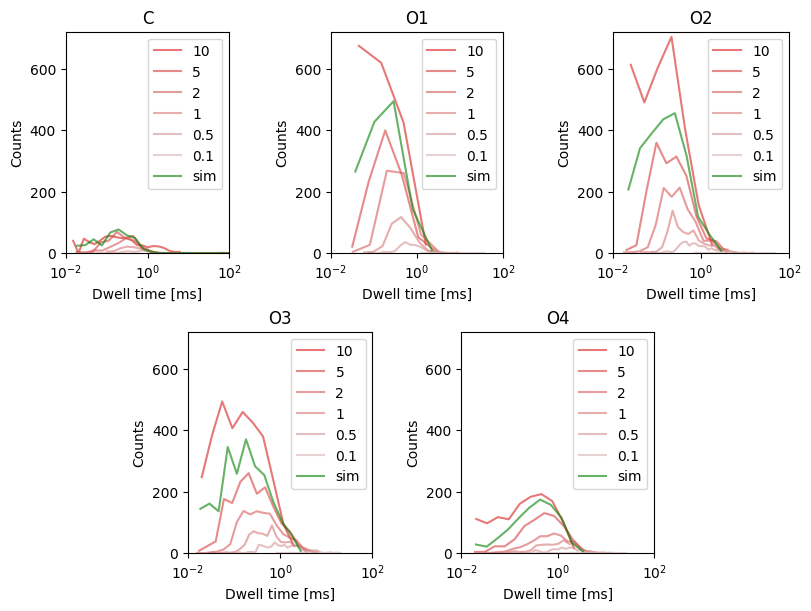

In [223]:
dwell_times_tc_figure(dataDir, 1, 2, 10e4, tc_amplitudes[0], 0.13*1e-3)
#plt.savefig(f"{figDir}/tc-dwells-figure.pdf")
#plt.savefig(f"{figDir}/tc-dwells-figure.png")

In [51]:
levels = [-0.0, -0.61, -1.23, -1.82, -2.46]
np.mean(np.ediff1d(levels))

-0.615

In [33]:
def dwellTimesFromQ(Q, state):
    dwellTimeDistributionRateConstant = 1/Q[state,state]
    def dwellTimeDist(x):
        return -np.exp(x/dwellTimeDistributionRateConstant)/dwellTimeDistributionRateConstant
    dwelltimes = np.random.default_rng().exponential(-dwellTimeDistributionRateConstant, size=10000)
    return dwellTimeDist, dwelltimes
def dwellTimeSummary(denemeDir, state):
    Q = np.load(f"{denemeDir}/Q.npy")*1e-3
    dist_func, theo_samples = dwellTimesFromQ(Q, state)
    
    simulatedDwellTimes = np.load(f"{denemeDir}/true-dwellTimes.npy")
    simulatedTransitions = np.load(f"{denemeDir}/true-transitions.npy")
    
    sim_samples = simulatedDwellTimes[simulatedTransitions == state]  # in ms
    # print(f"{len(sim_samples[sim_samples <= 0.3321 / 1e3])} events shorter than rise time")
    print(f"{len(sim_samples[sim_samples <= 2 * 0.3321 / 10e3])} events shorter than 2x rise time")
    sim_samples *= 1e3
    f, a = plt.subplots()
    counts, bins, h = a.hist(sim_samples, density=True, bins=30, label='simulated')
    xmin, xmax = a.get_xlim()
    x = np.linspace(0, xmax, 10000)
    
    a.plot(x, dist_func(x), label='theoretical')
    a.legend()
    a.set_title(f"state={state}, {len(sim_samples)} events, Qii = {np.round(Q[state, state],3)}, mean {np.round(1/Q[state, state], 3)}")
    a.set_xlabel("Duration [ms]")
    a.set_ylabel("pdf")
    
    # f.savefig(f"{denemeDir}/{state}-dwellTimes_linear.png")

    return f, a, dist_func

def pooledDwellTimes(denemeDir, state, statename, pooled, density=True):
    cleanTrace = np.load(f"{denemeDir}/clean-current-trace-samplerate160000.npy")
    Q = np.load(f"{denemeDir}/Q.npy")*1e-3
    time = np.linspace(0, 2, 2*160000)
    eventlist = Idealizer.extract_events(cleanTrace, time)
    states = np.sort(np.unique(cleanTrace))[-1::-1]
    durations = eventlist[:,1][eventlist[:,0] == states[state]]
    #print(f"{len(durations[durations <= 0.3321 / 1e3])} events shorter than rise time")
    print(f"{len(durations[durations <= 2 * 0.3321 / 10e3])} events shorter than 2x rise time")
    durations *= 1e3
    
    f, ax = plt.subplots()
    ax.hist(durations, bins=30, density=density, label='observed')
    ax.set_title(f"{statename} at {np.round(states[state]*1e12, 2)} pA")
    ax.set_xlabel("Time [ms]")
    if density:
        ax.set_ylabel("pdf")
    else:
        ax.set_ylabel("Counts")
    f.savefig(f"{denemeDir}/{statename}-pooled-dwellTimes_linear-density{density}.png")
    # xmin, xmax = ax.get_xlim()
    # xmax = 0.002
    # x = np.linspace(0, xmax, 100000)
    # dwellTimeDistributionRateConstant = 1/np.mean(Q[pooled,pooled])
    # def dwellTimeDist(x):
    #     return -np.exp(x/dwellTimeDistributionRateConstant)/dwellTimeDistributionRateConstant
    
    # ax.plot(x, dwellTimeDist(x))

5 events shorter than 2x rise time
5 events shorter than 2x rise time
8 events shorter than 2x rise time
8 events shorter than 2x rise time
10 events shorter than 2x rise time
10 events shorter than 2x rise time
14 events shorter than 2x rise time
14 events shorter than 2x rise time
4 events shorter than 2x rise time
4 events shorter than 2x rise time


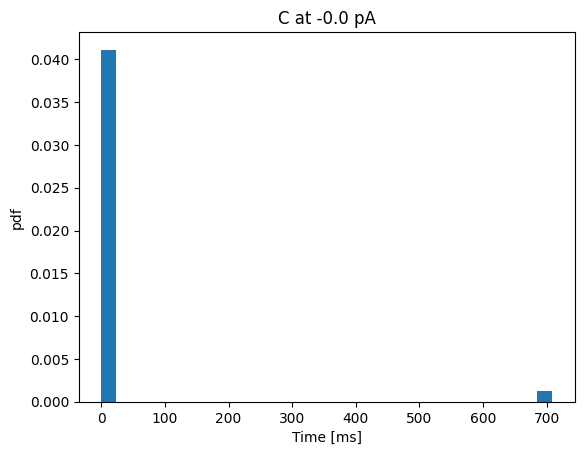

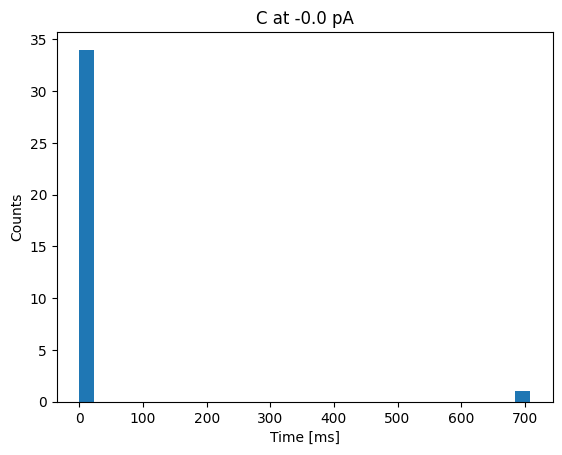

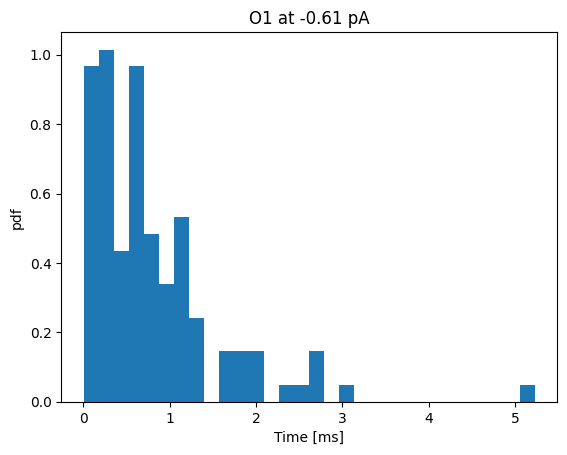

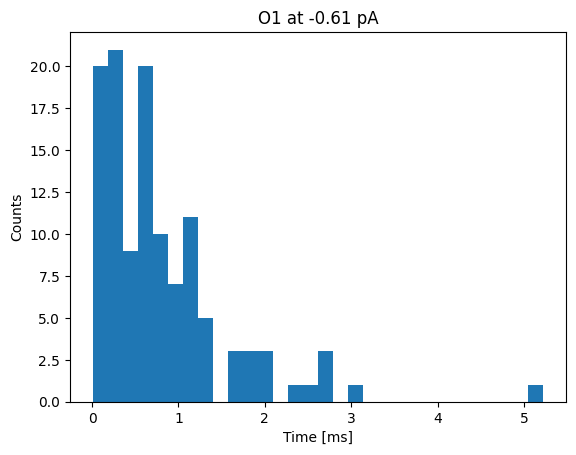

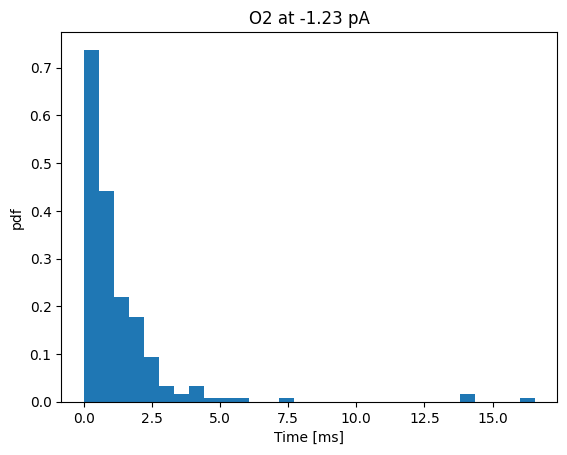

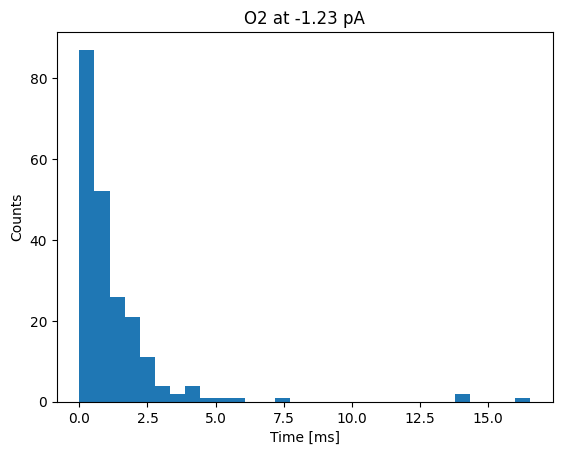

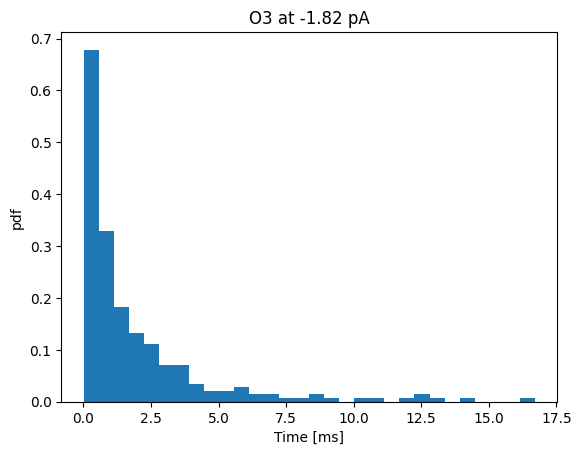

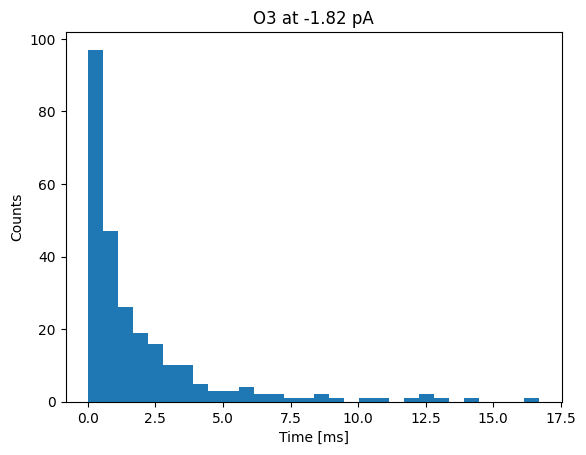

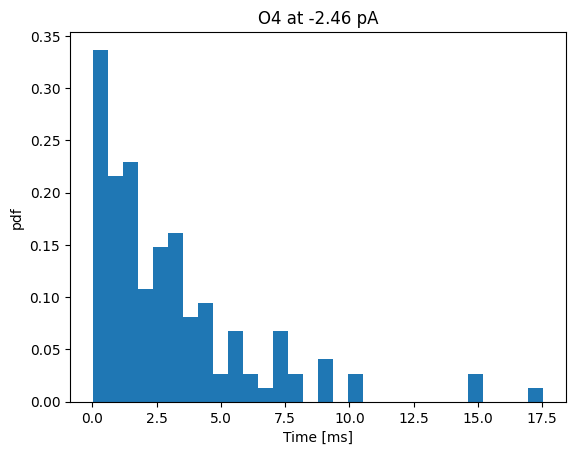

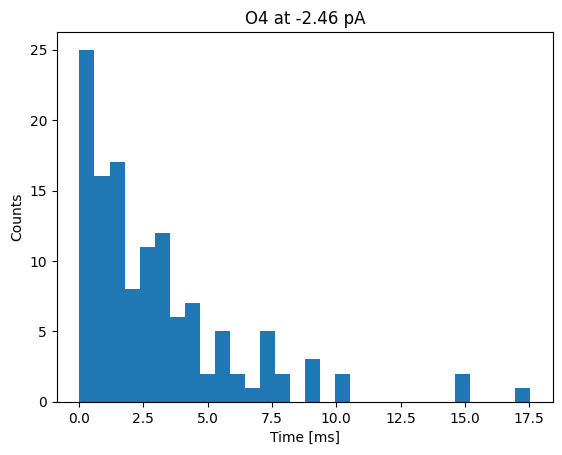

In [43]:
statenames = ["C"] + [f"O{i+1}" for i in range(4)]
pooled = ((14, 13, 12, 11, 10), (9, 8, 7, 6), (5, 4, 3), (2, 1), (0,))
for state, statename in enumerate(statenames):
    pooledDwellTimes(denemeDir, state, statename, pooled[state])
    pooledDwellTimes(denemeDir, state, statename, pooled[state], density=False)

5 events shorter than 2x rise time
16 events shorter than 2x rise time
0 events shorter than 2x rise time
4 events shorter than 2x rise time
6 events shorter than 2x rise time
0 events shorter than 2x rise time
1 events shorter than 2x rise time
7 events shorter than 2x rise time
1 events shorter than 2x rise time
1 events shorter than 2x rise time
1 events shorter than 2x rise time
3 events shorter than 2x rise time
1 events shorter than 2x rise time
0 events shorter than 2x rise time
0 events shorter than 2x rise time


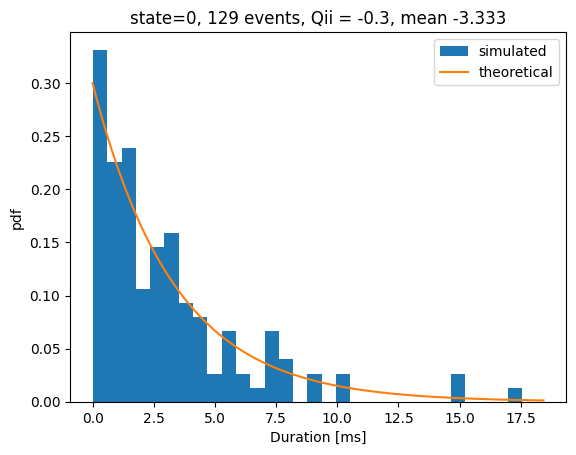

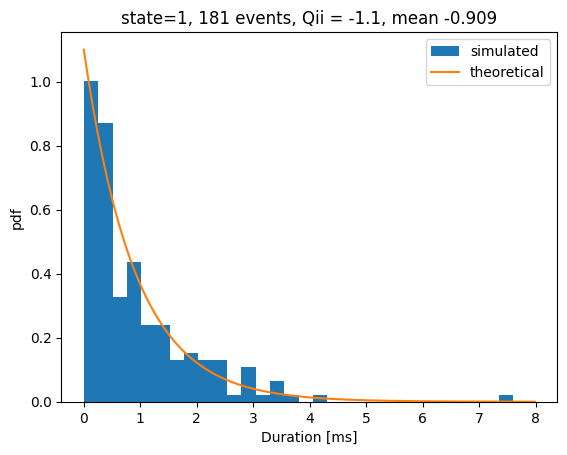

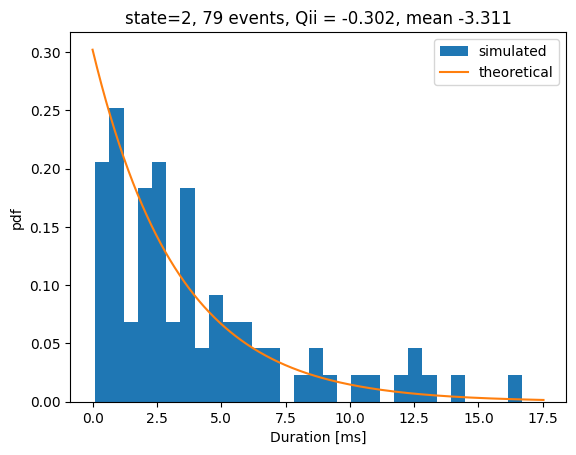

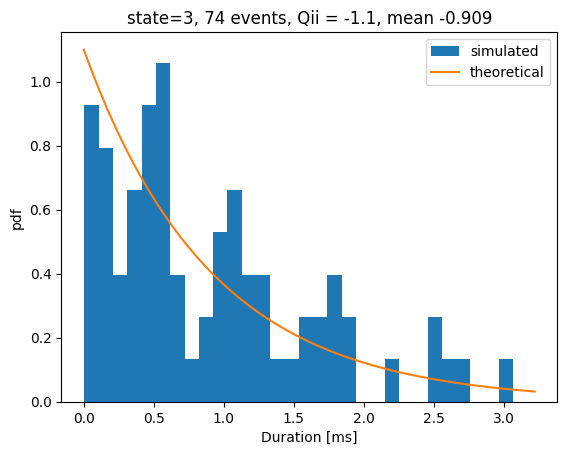

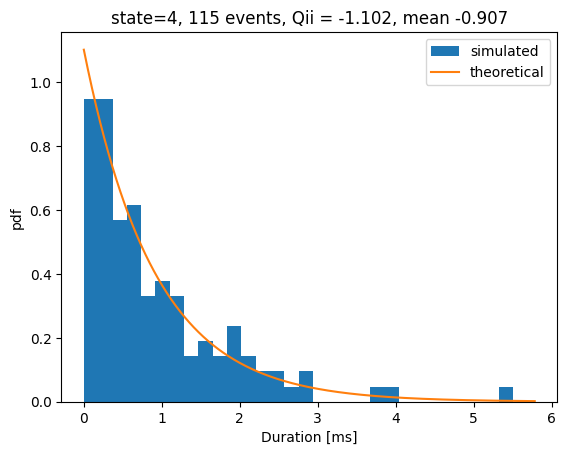

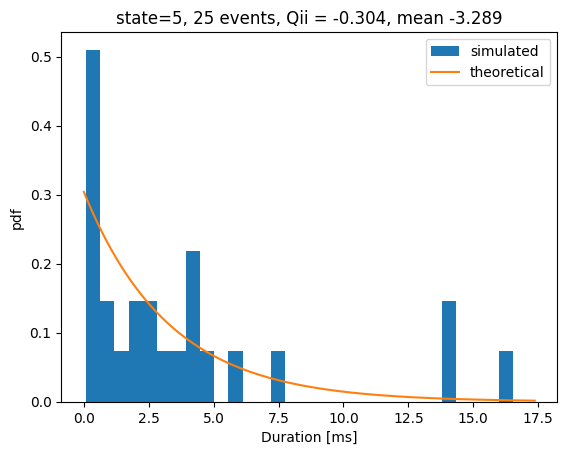

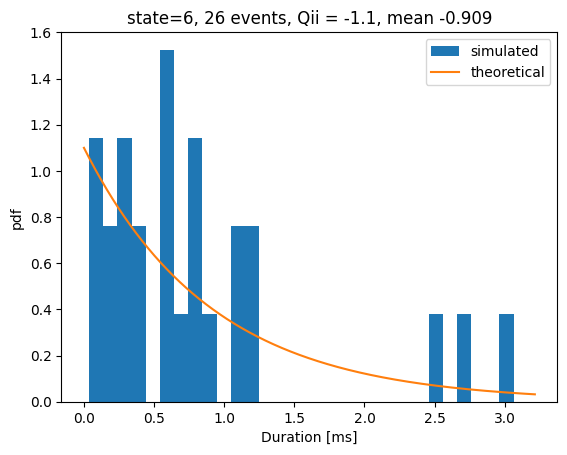

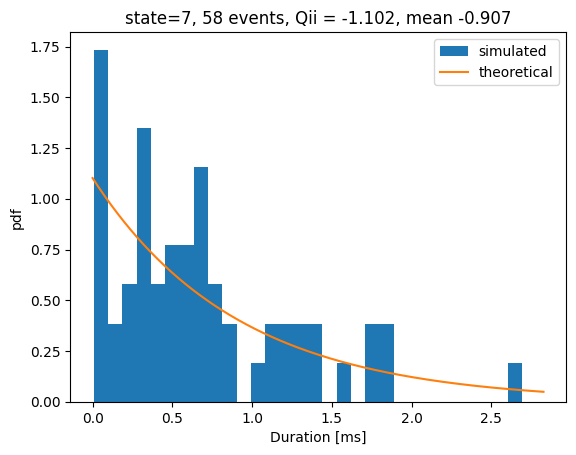

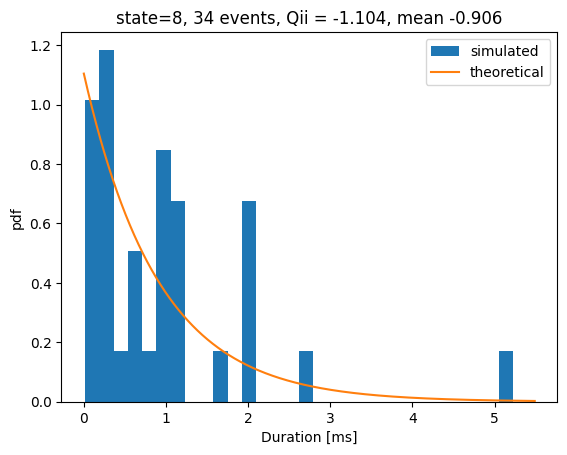

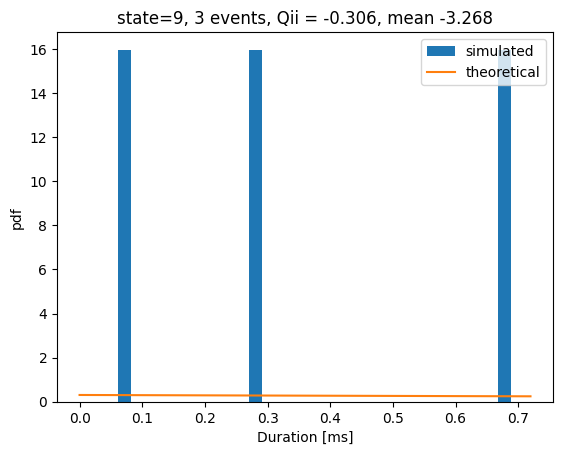

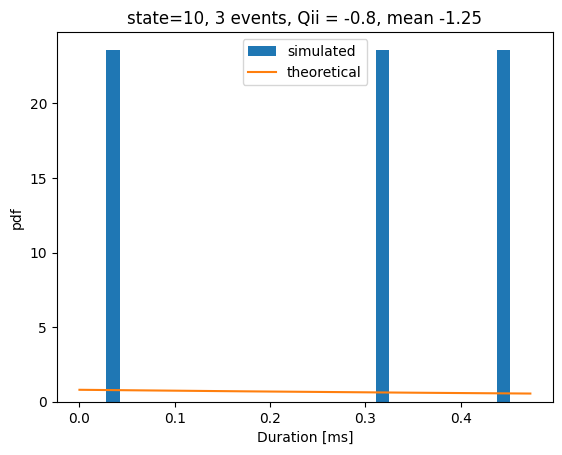

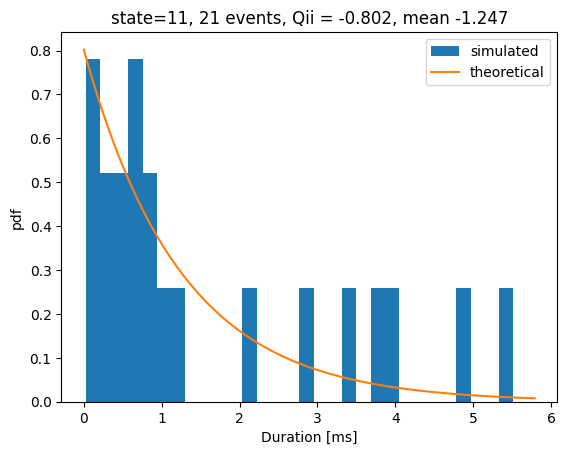

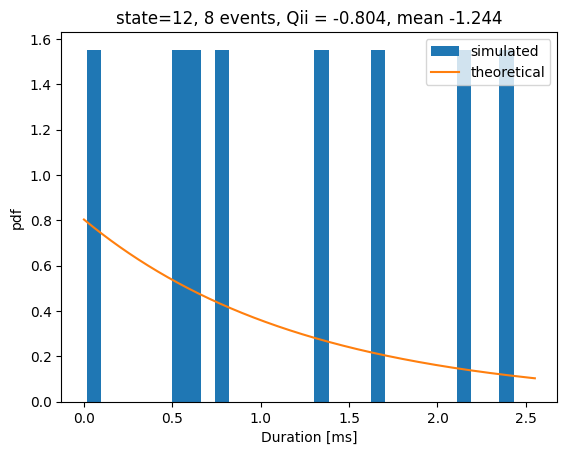

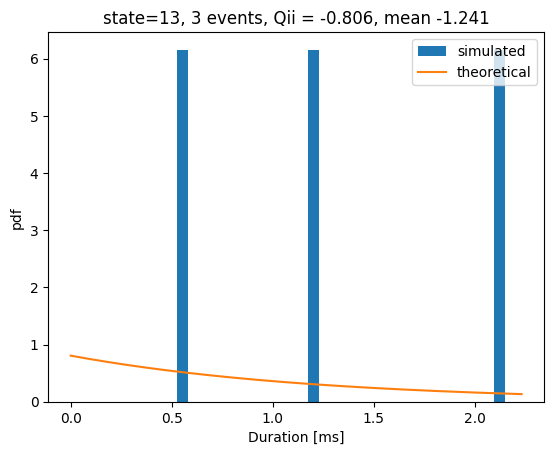

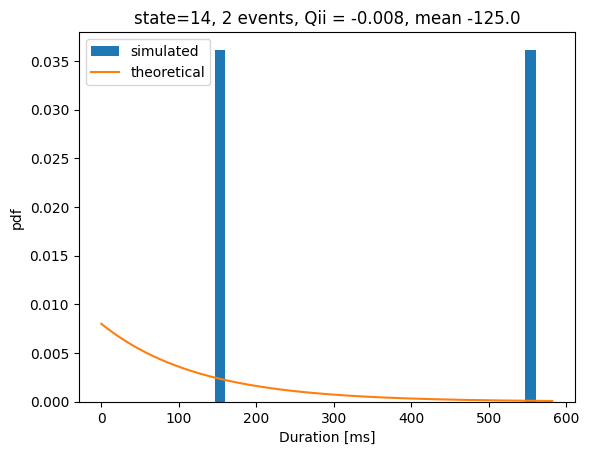

In [42]:
for i in range(15):
    dwellTimeSummary(denemeDir, i)

In [62]:
3 + 15 +3+ 1+ 3+ 2+ 7+ 1+ 2

37

In [295]:
plt.close()

3 events shorter than 2x rise time


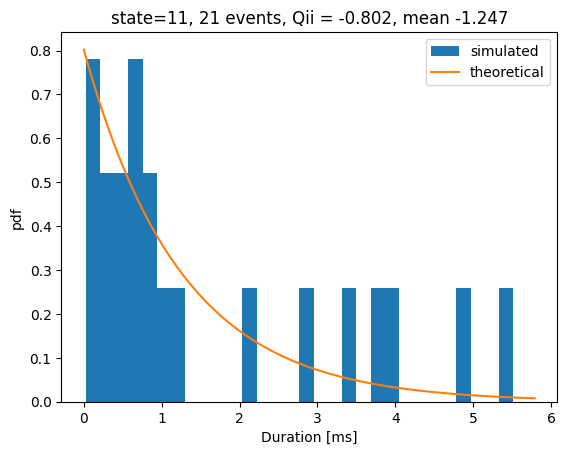

In [48]:
f, a, pdf = dwellTimeSummary(denemeDir, 11)


64005.4 points per second
[-2.464 -1.824 -1.232 -0.608 -0.   ]
108800, 120000
[-0.00632689 -0.00632689 -0.00632689 ... -2.46579348 -2.46579348
 -2.46579348]


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'staircase, SNR 7, f 10.0 kHz, samplerate 160000, alpha 0.001'}, xlabel='Time [ms]', ylabel='Current [pA]'>)

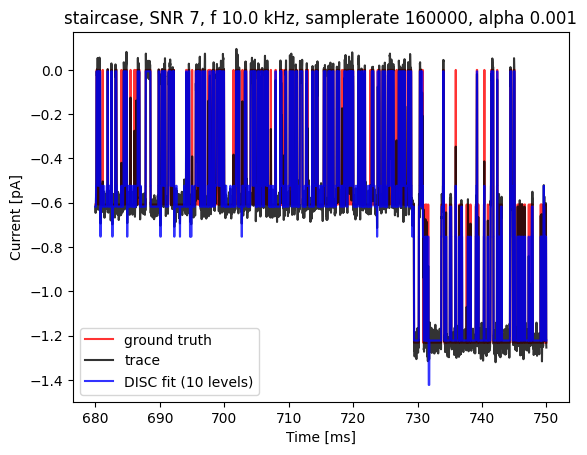

In [50]:
plot_disc_results(
    denemeDir, 680, 750, 'staircase', snr=7, filterfreq=10000, samplerate=160000, 
    alpha=1e-3,
)

In [14]:
def summarize(fitdir):
    nlevels = []
    samplerates = []
    filterfreqs = []
    snrs = []
    for fitfilename in os.listdir(fitdir):
        if fitfilename.startswith('noisy') and "Alpha" in fitfilename:
            if '160000' in fitfilename:
                break
            fitdata = np.load(f"{fitdir}/{fitfilename}") * 1e12
            levels = np.sort(np.unique(fitdata))
            nlevels.append(len(levels))
            
            samplerate = fitfilename.split('samplerate')[1].split('-')[0]
            if 'gf' in fitfilename:
                filterfreq = fitfilename.split('gf')[1].split('_')[0]
            else:
                filterfreq = 0
            snr = fitfilename.split('SNR')[1].split('_')[0].split('-')[0]
            
            samplerates.append(int(samplerate))
            snrs.append(int(snr))
            filterfreqs.append(int(filterfreq))

    return np.array(nlevels), np.array(samplerates), np.array(filterfreqs), np.array(snrs)

In [10]:
nlevels, samplerates, freqs, snrs = summarize(denemeDir)

In [11]:
def counts_table(nlevels, parameter):
    counts_list = []
    unique_ps = []
    for i, unique_p in enumerate(np.unique(parameter)):
        unique_ps.append(unique_p)
        n_p = nlevels[parameter == unique_p]
        counts = {}
        for n in np.unique(n_p):
            counts[str(n)] = sum(n_p==n)
        counts_list.append(counts)
    return counts_list, unique_ps

In [12]:
def counts_plot(counts, uniques):
    fig, ax = plt.subplots()
    shapes = ['x', 'v', 's', '^', '>', '<', 'p']
    for i, countdict in enumerate(counts):
        ax.plot(list(map(int, countdict)), countdict.values(), alpha=0.7)
        ax.scatter(list(map(int, countdict)), countdict.values(), marker=shapes[i], alpha=0.5, label=uniques[i])
    ax.legend()
    return fig, ax

In [13]:
samplerate_counts, u_samplerates = counts_table(nlevels, samplerates)
snr_counts, u_snrs = counts_table(nlevels, snrs)
freq_counts, u_freqs = counts_table(nlevels, freqs)

Text(0.5, 1.0, 'Sample rate vs DISC levels')

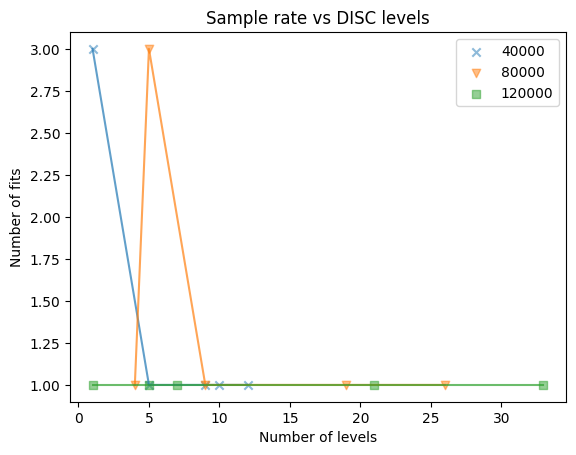

In [190]:
f, a = counts_plot(samplerate_counts, u_samplerates)
a.set_xlabel("Number of levels")
a.set_ylabel("Number of fits")
a.set_title("Sample rate vs DISC levels")

Text(0.5, 1.0, 'Filter frequency vs DISC levels')

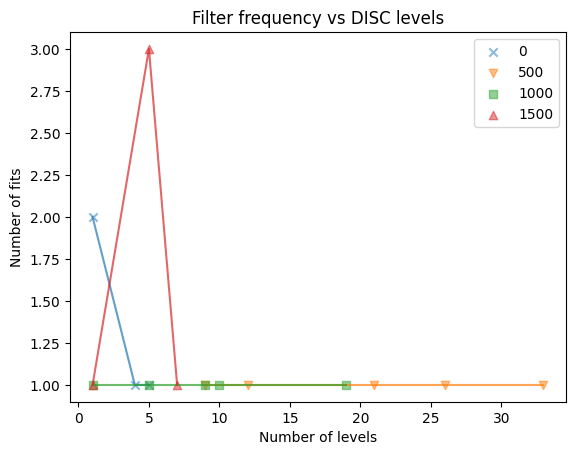

In [191]:
f, a = counts_plot(freq_counts, u_freqs)
a.set_xlabel("Number of levels")
a.set_ylabel("Number of fits")
a.set_title("Filter frequency vs DISC levels")

Text(0.5, 1.0, 'SNR vs DISC levels')

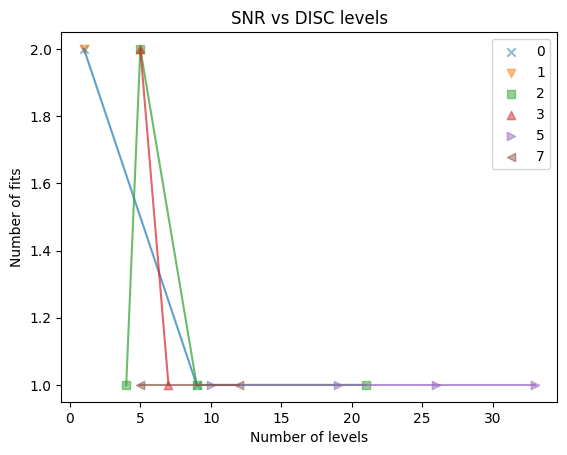

In [192]:
f, a = counts_plot(snr_counts, u_snrs)
a.set_xlabel("Number of levels")
a.set_ylabel("Number of fits")
a.set_title("SNR vs DISC levels")

In [51]:
def macroscopics(Q, g_i, v=-80e-3, vrev=0, N=200):
    Qmin = Q*-1
    lambdas = np.linalg.eigvals(Qmin)
    lambda_i = np.sort(lambdas)
    lambda_i[np.argmin(abs(lambda_i))] = 0
    tau = 1/ lambda_i[1:]
    tau_i = np.hstack([[0], tau])
    v_i = np.linalg.eig(Qmin)[1]
    vtemp = [np.zeros_like(v_i[0]) for k in v_i]
    for i, l in enumerate(lambda_i):
        pos = np.argmax(lambda_i==l)
        vtemp[i] = v_i[pos]
    x = np.vstack(vtemp)
    y = np.linalg.inv(x)
    A_i = []
    for i in range(len(x[0,:])-1, -1, -1):
        a = np.outer(x[:,i], y[i,:])
        A_i.append(a)
    p0 = np.zeros(Q.shape[0])
    p0[-1] = 1
    pinf = np.array(A_i[0][0,:])
    Iinf = (v - vrev)*sum(g_i * pinf)
    def I(t):
        current = Iinf
        for i in range(1, len(p0)):
            b_i = N * (v-vrev)*sum([p0r*gij*A_i[i][r, j] for r, p0r in enumerate(p0) for j, gij in enumerate(g_i)]) 
            current += b_i*np.exp(-t / tau_i[i])
        return current
    return I

In [52]:
glist = np.load(f"{denemeDir}conductances.npy")
Q = np.load(f"{denemeDir}Q.npy")

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

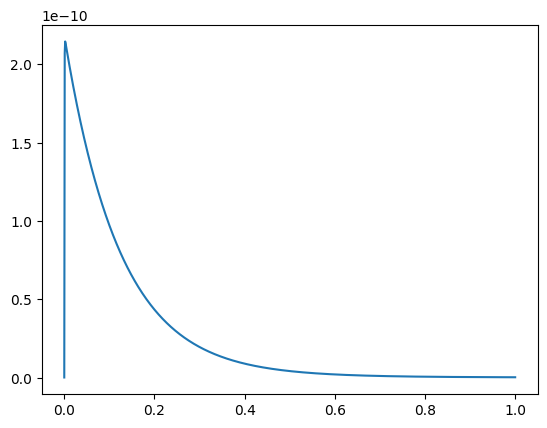

In [56]:
Imacro = macroscopics(Q, glist, N=100)
t = np.linspace(0,1, 1000)
ilist = [Imacro(ti) for ti in t]
plt.plot(t, ilist)
ilist[-1]
Imacro(t[0])
plt.xlabel

In [17]:
glist

array([3.08e-11, 2.28e-11, 2.28e-11, 1.54e-11, 1.54e-11, 1.54e-11,
       7.60e-12, 7.60e-12, 7.60e-12, 7.60e-12, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00])

In [260]:
Qblue = np.array([
    [-3.050, 0.05, 0, 3, 0],
    [0.000666667, -0.500666667, 0.5, 0, 0],
    [0, 15, -19, 4, 0],
    [0.015, 0, 0.05, -2.065, 2],
    [0, 0, 0, 0.01, -0.01]
])
glistb = np.array([40, 50, 0, 0, 0]) * 1e-12